# Part 3.1: Classical Machine Learning

Before diving into deep learning, you need to understand the algorithms that dominated machine learning for decades — and still outperform neural networks on many real-world problems. Classical ML algorithms are the foundation:
- They're **interpretable** — you can explain *why* a prediction was made
- They work with **small datasets** where deep learning would overfit
- They're **fast** to train and deploy
- They're the **baseline** that every deep learning model must beat to justify its complexity

And here's the thing: **F1 teams use classical ML constantly**. Predicting tire degradation curves, classifying optimal pit stop windows, clustering circuits by characteristics, evaluating whether a setup change will improve qualifying pace — these are all classical ML problems. The strategy wall at any Grand Prix is running models that look a lot more like Random Forests than transformers.

This notebook covers decision trees, ensemble methods, SVMs, clustering, and model evaluation — the toolkit every ML practitioner needs before moving to neural networks. We'll learn each algorithm through the lens of Formula 1 racing.

## Learning Objectives
- [ ] Build decision trees from scratch and understand information gain / Gini impurity
- [ ] Explain why ensembles (Random Forests, Gradient Boosting) beat single models
- [ ] Visualize SVM decision boundaries and understand the kernel trick
- [ ] Apply k-means and DBSCAN clustering to discover structure in data
- [ ] Evaluate models with cross-validation, confusion matrices, and ROC curves
- [ ] Know when classical ML is the right choice over deep learning

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.datasets import make_moons, make_blobs, make_classification
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

---

## 1. Decision Trees

### Intuitive Explanation

A decision tree works exactly like the split-second decisions on an F1 strategy wall. To make a call, the team asks a series of yes/no questions about the current race state, branching at each step until they reach a decision.

**Example**: Should we pit this lap?
1. Is rain expected in the next 5 laps? **No** -->
2. Are the tires more than 15 laps old? **Yes** -->
3. Is there a gap to pit without losing position? **Yes** -->
4. Decision: **Box, box, box!**

The key question is: **which question should the tree ask first?** The answer: whichever question best separates the outcomes. We measure this with *information gain* or *Gini impurity*.

### The F1 Connection

Think of every node in a decision tree as a race engineer asking a question about telemetry or race conditions. The tree learns which questions most effectively separate "pit now" from "stay out," or "podium finish" from "points finish." Just like an experienced strategist knows to check tire wear before fuel load, the tree learns the optimal order of questions from historical data.

### Splitting Criteria

| Criterion | Formula | Intuition | F1 Parallel |
|-----------|---------|-----------|-------------|
| **Gini Impurity** | $G = 1 - \sum_{k=1}^{K} p_k^2$ | Probability of misclassifying a randomly chosen sample | How "mixed" your pit strategy outcomes are — pure = all wins or all losses |
| **Entropy** | $H = -\sum_{k=1}^{K} p_k \log_2(p_k)$ | Amount of "surprise" or disorder | Uncertainty about race outcome before checking a telemetry reading |
| **Information Gain** | $IG = H(parent) - \sum \frac{n_i}{n} H(child_i)$ | Reduction in uncertainty after splitting | How much checking tire temperature reduces uncertainty about optimal pit window |

**What this means:** A pure node (all same class) has Gini = 0 and Entropy = 0. A maximally impure node (50/50 split) has Gini = 0.5 and Entropy = 1.0. The tree greedily picks the split that reduces impurity the most.

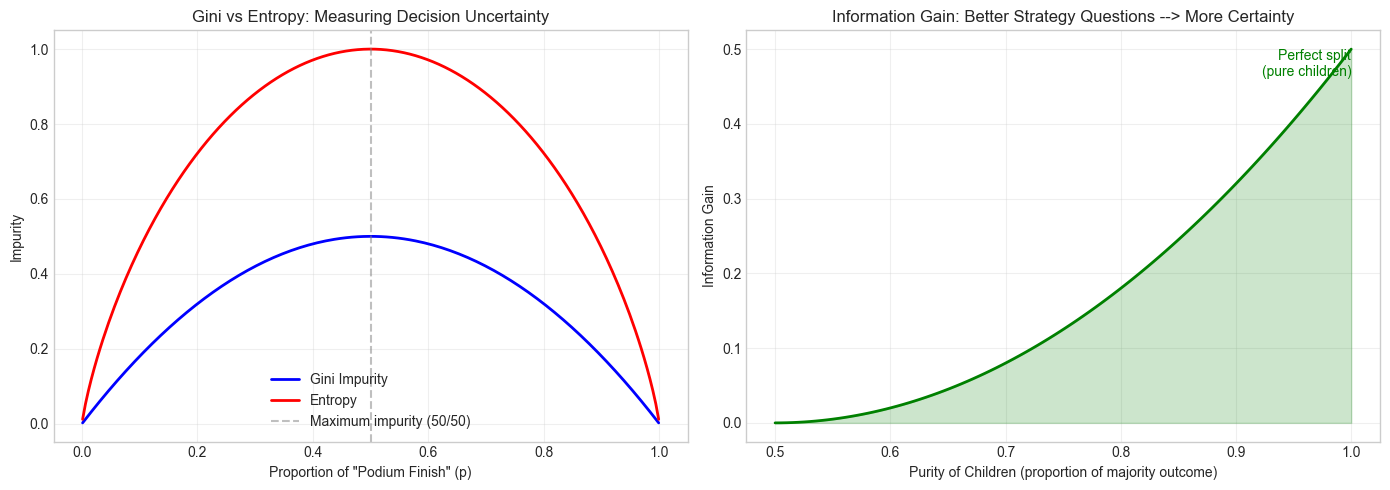

Key takeaway: Both Gini and Entropy measure the same thing — impurity.
Gini is faster to compute; Entropy gives slightly more balanced trees.
In practice, the difference is negligible — like choosing between
two equally fast pit stop strategies.


In [2]:
# Visualize Gini Impurity and Entropy
p = np.linspace(0.001, 0.999, 200)
gini = 1 - p**2 - (1-p)**2
entropy = -p * np.log2(p) - (1-p) * np.log2(1-p)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Gini vs Entropy
axes[0].plot(p, gini, 'b-', linewidth=2, label='Gini Impurity')
axes[0].plot(p, entropy, 'r-', linewidth=2, label='Entropy')
axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Maximum impurity (50/50)')
axes[0].set_xlabel('Proportion of "Podium Finish" (p)')
axes[0].set_ylabel('Impurity')
axes[0].set_title('Gini vs Entropy: Measuring Decision Uncertainty')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Information Gain example
# Parent: 50/50 split (max impurity)
# After split: one child is 80/20, other is 20/80
parent_gini = 0.5
splits = np.linspace(0.5, 1.0, 100)
child_gini = 1 - splits**2 - (1-splits)**2
# Assume equal-sized children, mirror split
ig = parent_gini - child_gini  # simplified for equal-sized, symmetric children

axes[1].plot(splits, ig, 'g-', linewidth=2)
axes[1].fill_between(splits, 0, ig, alpha=0.2, color='green')
axes[1].set_xlabel('Purity of Children (proportion of majority outcome)')
axes[1].set_ylabel('Information Gain')
axes[1].set_title('Information Gain: Better Strategy Questions --> More Certainty')
axes[1].annotate('Perfect split\n(pure children)', xy=(1.0, 0.5), fontsize=10,
                  ha='right', va='top', color='green')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key takeaway: Both Gini and Entropy measure the same thing — impurity.")
print("Gini is faster to compute; Entropy gives slightly more balanced trees.")
print("In practice, the difference is negligible — like choosing between")
print("two equally fast pit stop strategies.")

### Deep Dive: Building a Decision Tree from Scratch

Let's implement the core logic of a decision tree to understand how splitting works. Imagine we're building a race strategy decision system — the algorithm is:

1. For each telemetry feature, try every possible split threshold
2. Calculate the information gain (reduction in uncertainty) for each split
3. Pick the split with the highest information gain
4. Recurse on the left and right children
5. Stop when a node is pure, reaches max depth, or has too few samples

#### Key Insight

Decision trees are **greedy** — they pick the locally best split at each step without considering future splits. This is like a strategist who only optimizes the next pit stop without considering the full race. It makes decisions fast but potentially suboptimal. This is why ensembles (coming next) work so much better — just like having a team of engineers rather than one person making calls alone.

In [3]:
def gini_impurity(y):
    """
    Calculate the Gini impurity of a set of labels.
    
    Args:
        y: Array of class labels (e.g., podium=1, no_podium=0)
    
    Returns:
        Gini impurity score (0 = pure, 0.5 = maximally impure for binary)
    """
    if len(y) == 0:
        return 0
    classes, counts = np.unique(y, return_counts=True)
    proportions = counts / len(y)
    return 1 - np.sum(proportions**2)


def information_gain(y, left_mask):
    """
    Calculate information gain from a binary split.
    
    Args:
        y: Array of class labels
        left_mask: Boolean mask for left child
    
    Returns:
        Information gain (higher is better)
    """
    parent_impurity = gini_impurity(y)
    left_y = y[left_mask]
    right_y = y[~left_mask]
    
    n = len(y)
    n_left = len(left_y)
    n_right = len(right_y)
    
    if n_left == 0 or n_right == 0:
        return 0
    
    child_impurity = (n_left / n) * gini_impurity(left_y) + (n_right / n) * gini_impurity(right_y)
    return parent_impurity - child_impurity


def find_best_split(X, y):
    """
    Find the best telemetry feature and threshold to split on.
    
    Args:
        X: Feature matrix (n_samples, n_features) — e.g., tire age, fuel load
        y: Class labels — e.g., podium vs no podium
    
    Returns:
        best_feature, best_threshold, best_gain
    """
    best_gain = 0
    best_feature = None
    best_threshold = None
    
    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_mask = X[:, feature] <= threshold
            gain = information_gain(y, left_mask)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold
    
    return best_feature, best_threshold, best_gain


# Demo: find the best split on simple race telemetry data
# Features: [avg_speed_kph, tire_wear_pct]
# Labels: 0 = no podium, 1 = podium
X_demo = np.array([[200, 30], [210, 35], [215, 25], [290, 10], [305, 15], [310, 5]])
y_demo = np.array([0, 0, 0, 1, 1, 1])

best_feat, best_thresh, best_gain = find_best_split(X_demo, y_demo)
feature_names_demo = ['avg_speed_kph', 'tire_wear_pct']
print(f"Best split: {feature_names_demo[best_feat]} <= {best_thresh}")
print(f"Information gain: {best_gain:.4f}")
print(f"\nThis means: split on {feature_names_demo[best_feat]} <= {best_thresh}")
print(f"No podium group: {X_demo[X_demo[:, best_feat] <= best_thresh]}")
print(f"Podium group:    {X_demo[X_demo[:, best_feat] > best_thresh]}")

Best split: avg_speed_kph <= 215
Information gain: 0.5000

This means: split on avg_speed_kph <= 215
No podium group: [[200  30]
 [210  35]
 [215  25]]
Podium group:    [[290  10]
 [305  15]
 [310   5]]


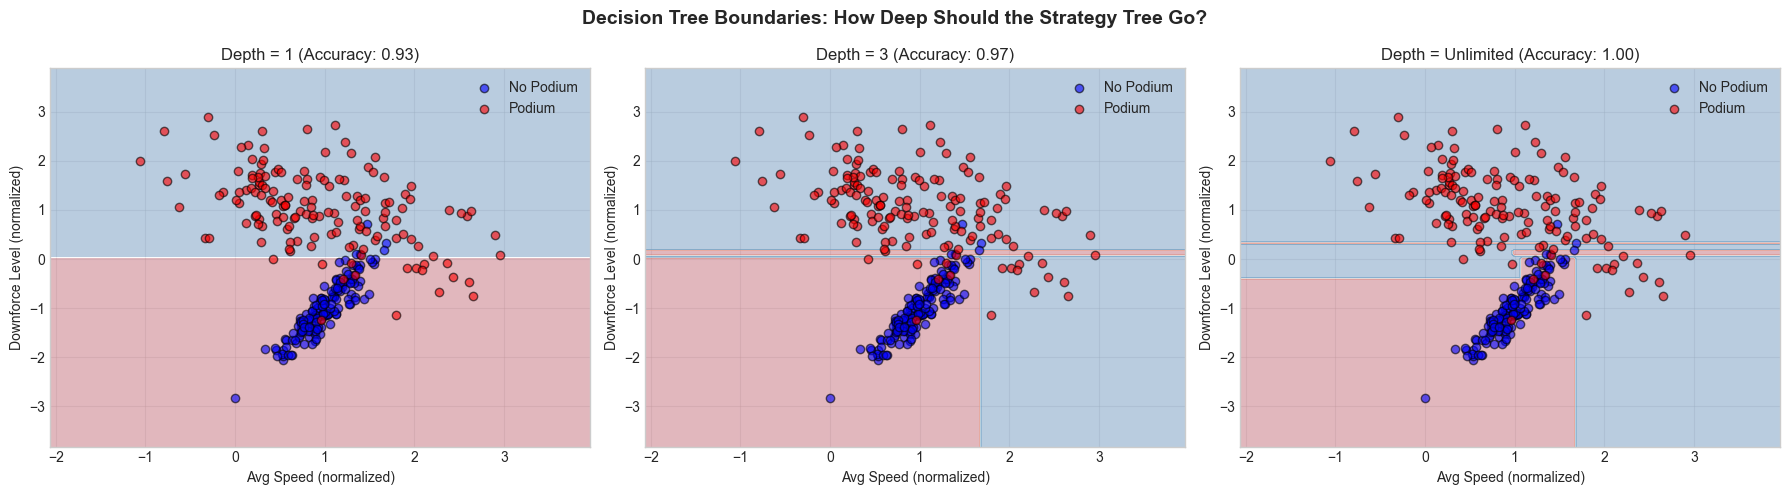

Notice: Deeper trees create more complex (jagged) boundaries.
Too deep --> overfitting (a setup perfect for one corner but terrible everywhere else).
Too shallow --> underfitting (a one-size-fits-all strategy that misses nuance).


In [4]:
# Now use sklearn's DecisionTreeClassifier and visualize
# Simulating race data: feature 1 = avg speed, feature 2 = downforce level
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=1, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, max_depth in enumerate([1, 3, None]):
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    tree.fit(X, y)
    
    # Create mesh for decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
    axes[idx].scatter(X[y==0, 0], X[y==0, 1], c='blue', edgecolors='k', alpha=0.6, label='No Podium')
    axes[idx].scatter(X[y==1, 0], X[y==1, 1], c='red', edgecolors='k', alpha=0.6, label='Podium')
    
    depth_label = max_depth if max_depth else 'Unlimited'
    score = tree.score(X, y)
    axes[idx].set_title(f'Depth = {depth_label} (Accuracy: {score:.2f})')
    axes[idx].set_xlabel('Avg Speed (normalized)')
    axes[idx].set_ylabel('Downforce Level (normalized)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Decision Tree Boundaries: How Deep Should the Strategy Tree Go?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Notice: Deeper trees create more complex (jagged) boundaries.")
print("Too deep --> overfitting (a setup perfect for one corner but terrible everywhere else).")
print("Too shallow --> underfitting (a one-size-fits-all strategy that misses nuance).")

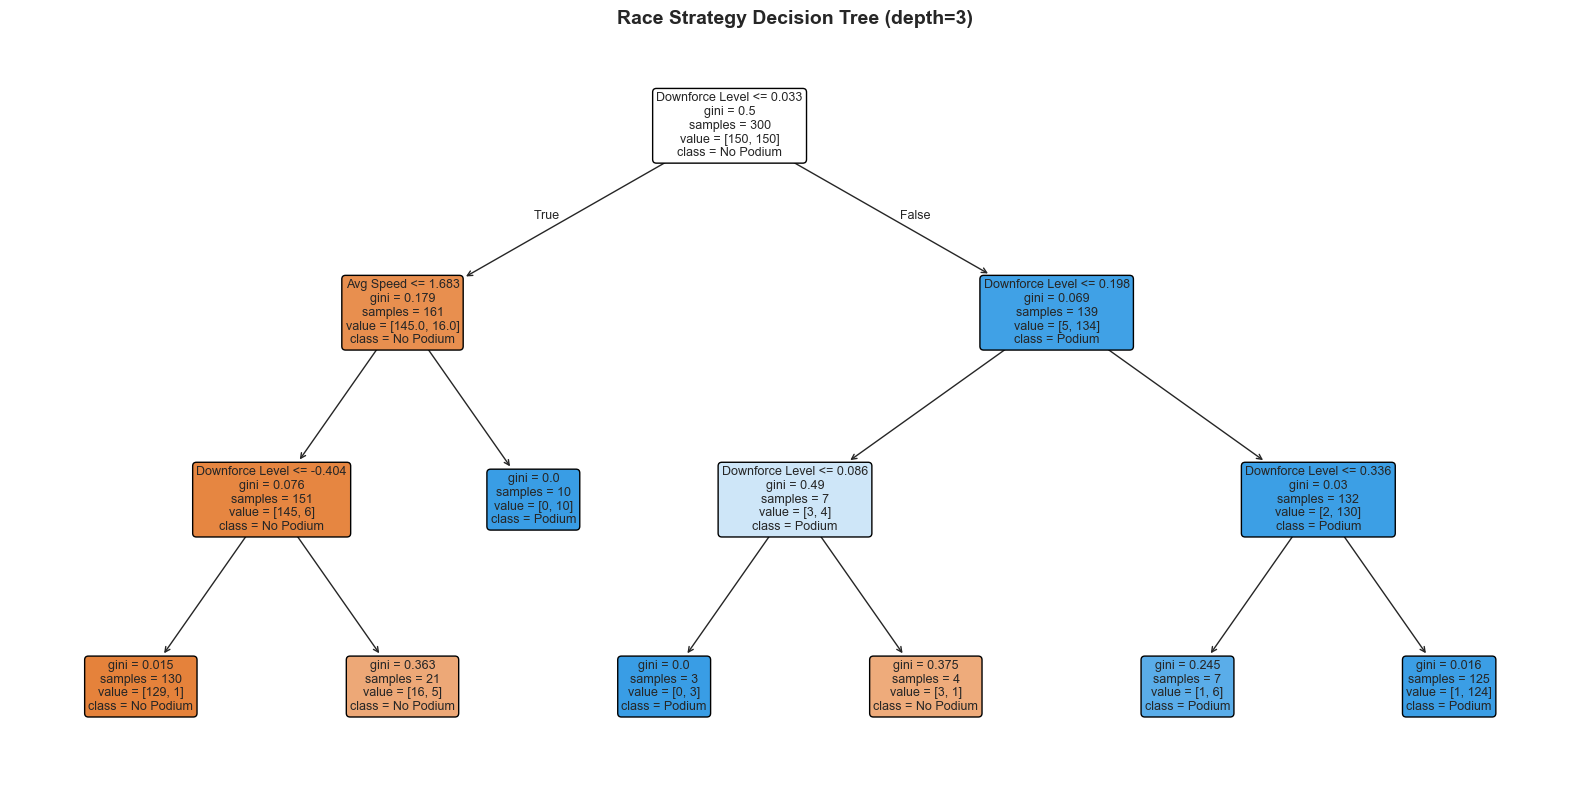

Reading the tree (just like a strategy flowchart on the pit wall):
- Each node shows: the split condition, Gini impurity, sample count, class distribution
- Blue nodes lean toward No Podium, orange nodes lean toward Podium
- Darker color = more confident prediction (lower impurity)


In [5]:
# Visualize the actual tree structure — like reading a strategy flowchart
tree_shallow = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_shallow.fit(X, y)

plt.figure(figsize=(16, 8))
plot_tree(tree_shallow, filled=True, feature_names=['Avg Speed', 'Downforce Level'],
          class_names=['No Podium', 'Podium'], rounded=True, fontsize=9)
plt.title('Race Strategy Decision Tree (depth=3)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Reading the tree (just like a strategy flowchart on the pit wall):")
print("- Each node shows: the split condition, Gini impurity, sample count, class distribution")
print("- Blue nodes lean toward No Podium, orange nodes lean toward Podium")
print("- Darker color = more confident prediction (lower impurity)")

### Common Misconceptions

| Misconception | Reality | F1 Parallel |
|---------------|--------|-------------|
| Deeper trees are always better | Deeper trees overfit — they memorize the training data instead of learning patterns | A setup optimized for every bump at one circuit will be terrible at the next |
| Decision trees find the globally optimal splits | They use **greedy** search — each split is locally optimal but the overall tree may not be | A strategist who only optimizes the next lap, not the full race |
| Decision trees can't handle continuous features | They can! They find the best threshold to split a continuous feature into two groups | Tire temp is continuous, but "above 100C = degradation zone" is a useful binary split |
| Decision trees are too simple for real problems | Single trees are weak, but ensembles of trees (Random Forests, XGBoost) win Kaggle competitions | One engineer might be wrong, but the whole strategy team rarely is |

---

## 2. Ensemble Methods

### Intuitive Explanation

A single decision tree is like having one race engineer make the pit call alone — they might be wrong. An ensemble is like the full strategy room: multiple engineers each analyzing different data streams, then voting on the best call. Even if each engineer is only slightly better than random, the team's collective decision is surprisingly accurate.

This is the **wisdom of the pit wall** applied to machine learning.

| Method | Strategy | F1 Parallel | Strength |
|--------|----------|-------------|----------|
| **Bagging** (Random Forest) | Train many trees on random subsets, vote | Each engineer analyzes a different subset of telemetry channels, then they vote | Robust, hard to overfit |
| **Boosting** (Gradient Boosting) | Train trees sequentially, each fixing previous mistakes | Each debrief focuses specifically on what went wrong last time | Higher accuracy, can overfit |
| **XGBoost** | Optimized gradient boosting with regularization | Best of both — thorough analysis with safeguards against overthinking | State-of-the-art on tabular data |

### Deep Dive: Why Ensembles Work

The magic of ensembles comes from the **bias-variance tradeoff** — a concept that maps perfectly to F1 strategy:

- **Bias**: How far off the model's average prediction is from the truth (systematic error). In F1: a **conservative strategy** that's consistently a few seconds off the pace.
- **Variance**: How much predictions change when you train on different data (instability). In F1: an **aggressive strategy** that sometimes wins by 20 seconds but sometimes DNFs.
- **Total Error = Bias² + Variance + Noise**

A single deep decision tree has **low bias** (it can fit complex patterns) but **high variance** (small changes in data lead to very different trees). Ensembles fix this:

- **Random Forests** (bagging): Average many high-variance trees --> variance drops, bias stays low. Like polling 100 engineers — individual errors cancel out.
- **Gradient Boosting**: Sequentially add low-bias trees that correct residual errors --> bias drops further. Like running post-race debriefs where each session specifically addresses what went wrong.

#### Key Insight

If each tree's errors are somewhat **independent** (which random feature selection encourages), then averaging N trees reduces variance by roughly 1/N. This is why Random Forests use random subsets of features at each split — it decorrelates the trees. In F1 terms: if each engineer independently analyzes different telemetry channels, their collective judgment is far more reliable than if they all looked at the same data.

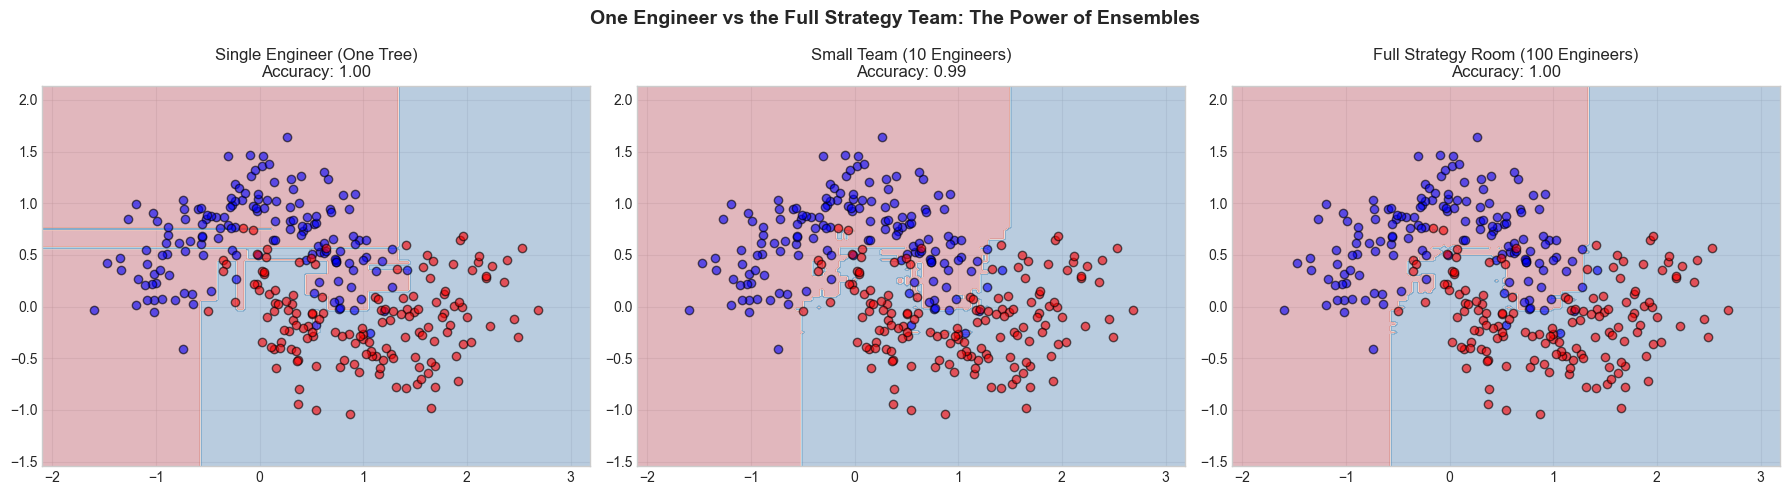

Notice how the team's boundary is smoother and more generalizable.
The single engineer overfits with jagged, irregular decisions.


In [6]:
# Random Forest: Single engineer vs the full strategy team
X_moons, y_moons = make_moons(n_samples=300, noise=0.25, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Single tree (one engineer's opinion)
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_moons, y_moons)

x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[0].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
axes[0].scatter(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], c='blue', edgecolors='k', alpha=0.6)
axes[0].scatter(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], c='red', edgecolors='k', alpha=0.6)
axes[0].set_title(f'Single Engineer (One Tree)\nAccuracy: {tree.score(X_moons, y_moons):.2f}')
axes[0].grid(True, alpha=0.3)

# Random Forest (10 engineers)
rf_small = RandomForestClassifier(n_estimators=10, random_state=42)
rf_small.fit(X_moons, y_moons)
Z = rf_small.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[1].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
axes[1].scatter(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], c='blue', edgecolors='k', alpha=0.6)
axes[1].scatter(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], c='red', edgecolors='k', alpha=0.6)
axes[1].set_title(f'Small Team (10 Engineers)\nAccuracy: {rf_small.score(X_moons, y_moons):.2f}')
axes[1].grid(True, alpha=0.3)

# Random Forest (100 engineers)
rf_large = RandomForestClassifier(n_estimators=100, random_state=42)
rf_large.fit(X_moons, y_moons)
Z = rf_large.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[2].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
axes[2].scatter(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], c='blue', edgecolors='k', alpha=0.6)
axes[2].scatter(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], c='red', edgecolors='k', alpha=0.6)
axes[2].set_title(f'Full Strategy Room (100 Engineers)\nAccuracy: {rf_large.score(X_moons, y_moons):.2f}')
axes[2].grid(True, alpha=0.3)

plt.suptitle('One Engineer vs the Full Strategy Team: The Power of Ensembles', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Notice how the team's boundary is smoother and more generalizable.")
print("The single engineer overfits with jagged, irregular decisions.")

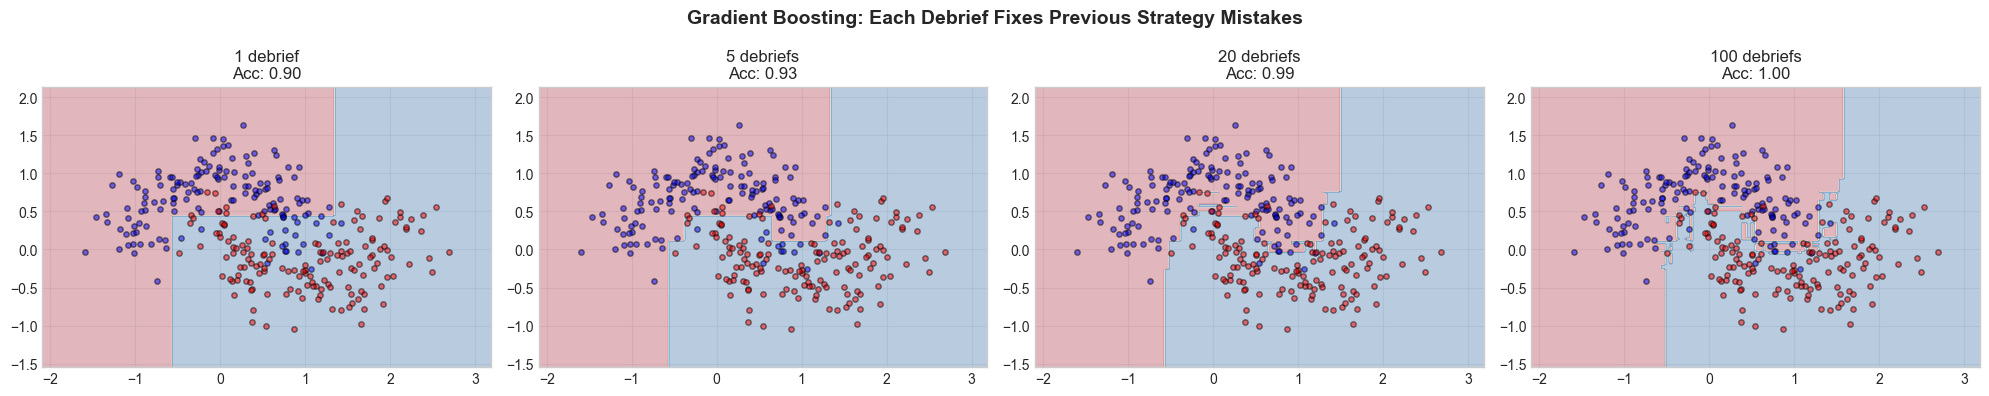

Key difference from Random Forest:
- Random Forest: engineers work independently (parallel), then vote
- Gradient Boosting: sequential debriefs, each one correcting what went wrong
- Gradient Boosting often achieves higher accuracy but risks overthinking (overfitting)


In [7]:
# Gradient Boosting: Watch the model improve through iterative debriefs
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for idx, n_estimators in enumerate([1, 5, 20, 100]):
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=2,
                                    learning_rate=0.5, random_state=42)
    gb.fit(X_moons, y_moons)
    
    Z = gb.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
    axes[idx].scatter(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], c='blue', edgecolors='k', alpha=0.5, s=15)
    axes[idx].scatter(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], c='red', edgecolors='k', alpha=0.5, s=15)
    axes[idx].set_title(f'{n_estimators} debrief{"s" if n_estimators > 1 else ""}\nAcc: {gb.score(X_moons, y_moons):.2f}')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Gradient Boosting: Each Debrief Fixes Previous Strategy Mistakes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Key difference from Random Forest:")
print("- Random Forest: engineers work independently (parallel), then vote")
print("- Gradient Boosting: sequential debriefs, each one correcting what went wrong")
print("- Gradient Boosting often achieves higher accuracy but risks overthinking (overfitting)")

In [8]:
# Compare all tree-based methods — the F1 strategy shootout
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, 
                                                     test_size=0.3, random_state=42)

models = {
    'Single Engineer (Tree)': DecisionTreeClassifier(random_state=42),
    'Strategy Team (RF 100)': RandomForestClassifier(n_estimators=100, random_state=42),
    'Debrief Loop (GB 100)': GradientBoostingClassifier(n_estimators=100, random_state=42),
}

print(f"{'Strategy Model':<30} {'Train Accuracy':>15} {'Test Accuracy':>15} {'CV Score (5 races)':>18}")
print('-' * 80)

for name, model in models.items():
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    cv_scores = cross_val_score(model, X_moons, y_moons, cv=5)
    print(f"{name:<30} {train_acc:>15.4f} {test_acc:>15.4f} {cv_scores.mean():>12.4f} +/- {cv_scores.std():.4f}")

print("\nNotice: The single engineer likely overfits (high train, lower test).")
print("The team approaches generalize better — their strategy works across different races.")

Strategy Model                  Train Accuracy   Test Accuracy CV Score (5 races)
--------------------------------------------------------------------------------
Single Engineer (Tree)                  1.0000          0.9222       0.8933 +/- 0.0170


Strategy Team (RF 100)                  1.0000          0.9222       0.9133 +/- 0.0125
Debrief Loop (GB 100)                   1.0000          0.9222       0.9033 +/- 0.0125

Notice: The single engineer likely overfits (high train, lower test).
The team approaches generalize better — their strategy works across different races.


---

## 3. Support Vector Machines (SVMs)

### Intuitive Explanation

Imagine you're looking at a circuit from above and you want to draw the **optimal racing line** — the path that gives you maximum margin from both the inside wall and the outside kerb. An SVM does exactly this: it finds the decision boundary that maximizes the **margin** (distance) between the boundary and the nearest points from each class.

These nearest points are called **support vectors** because they "support" (define) the boundary. If you moved any other point, the boundary wouldn't change — just like how the racing line is defined by the apex points and corner exits, not by what happens on the straights.

**What this means:** SVMs are fundamentally about finding the widest possible "gap" between two classes. A wider margin means better generalization to new data — like a racing line with more room for error.

### The Kernel Trick

What if the data isn't linearly separable? The **kernel trick** maps data into a higher-dimensional space where a linear boundary *does* exist — without actually computing the transformation.

| Kernel | What It Does | F1 Parallel |
|--------|-------------|-------------|
| **Linear** | No transformation (straight line) | A simple straight on the track — no tricks needed |
| **RBF (Gaussian)** | Maps to infinite dimensions via similarity | Reading the "character" of a circuit — nearby lap data is similar, distant data is not |
| **Polynomial** | Maps to polynomial feature space | Cornering dynamics that follow polynomial curves |

**Key Insight**: The kernel trick is mathematically elegant — it lets you compute dot products in a high-dimensional space without ever going there. The RBF kernel effectively measures how "similar" two points are; nearby points get high similarity, distant points get low similarity.

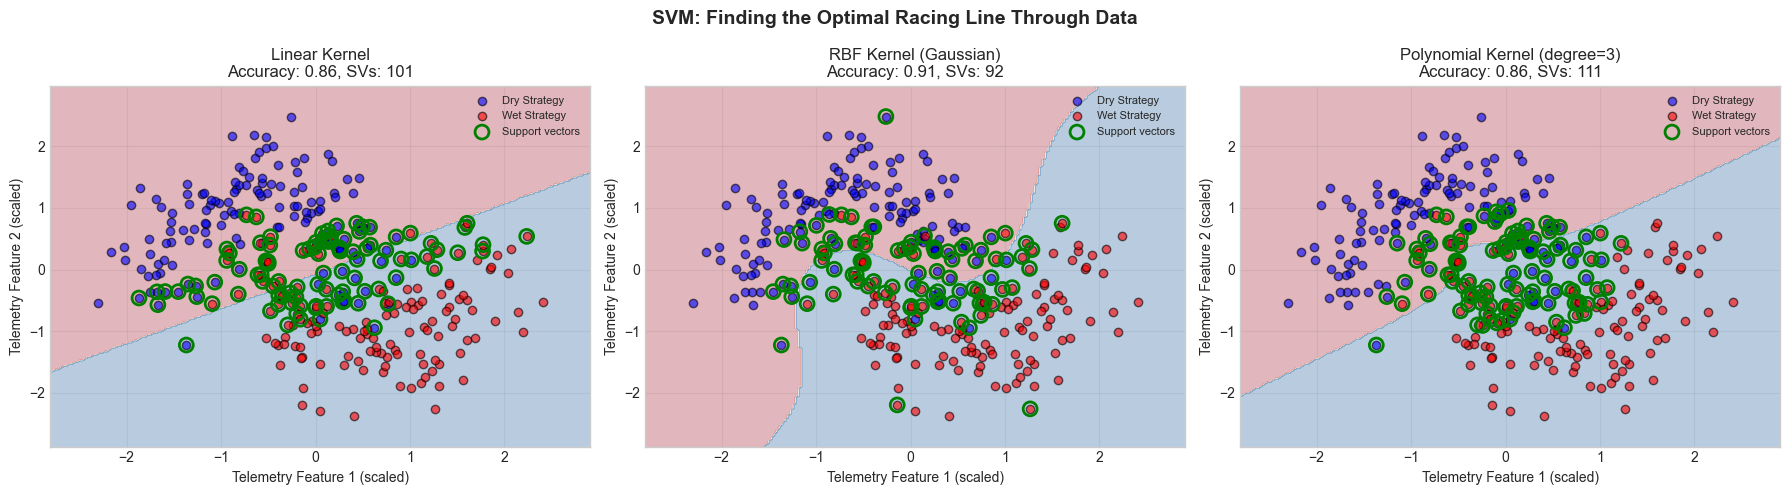

Green circles = support vectors (the apex points that define the racing line)
Linear kernel fails on nonlinear data; RBF handles it beautifully.
The kernel trick: map to higher dimensions where data IS linearly separable.


In [9]:
# SVM: Linear vs RBF kernel — finding the optimal racing line through data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scale data for SVM (SVMs are sensitive to feature scales, like tire pressures vs fuel load)
scaler = StandardScaler()
X_moons_scaled = scaler.fit_transform(X_moons)

x_min, x_max = X_moons_scaled[:, 0].min() - 0.5, X_moons_scaled[:, 0].max() + 0.5
y_min, y_max = X_moons_scaled[:, 1].min() - 0.5, X_moons_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

kernels = ['linear', 'rbf', 'poly']
kernel_names = ['Linear Kernel', 'RBF Kernel (Gaussian)', 'Polynomial Kernel (degree=3)']

for idx, (kernel, name) in enumerate(zip(kernels, kernel_names)):
    svm = SVC(kernel=kernel, C=1.0, random_state=42)
    svm.fit(X_moons_scaled, y_moons)
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
    axes[idx].scatter(X_moons_scaled[y_moons==0, 0], X_moons_scaled[y_moons==0, 1], 
                      c='blue', edgecolors='k', alpha=0.6, label='Dry Strategy')
    axes[idx].scatter(X_moons_scaled[y_moons==1, 0], X_moons_scaled[y_moons==1, 1], 
                      c='red', edgecolors='k', alpha=0.6, label='Wet Strategy')
    
    # Highlight support vectors — the critical apex points
    axes[idx].scatter(X_moons_scaled[svm.support_, 0], X_moons_scaled[svm.support_, 1],
                      s=100, facecolors='none', edgecolors='green', linewidths=2, label='Support vectors')
    
    axes[idx].set_title(f'{name}\nAccuracy: {svm.score(X_moons_scaled, y_moons):.2f}, SVs: {len(svm.support_)}')
    axes[idx].set_xlabel('Telemetry Feature 1 (scaled)')
    axes[idx].set_ylabel('Telemetry Feature 2 (scaled)')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('SVM: Finding the Optimal Racing Line Through Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Green circles = support vectors (the apex points that define the racing line)")
print("Linear kernel fails on nonlinear data; RBF handles it beautifully.")
print("The kernel trick: map to higher dimensions where data IS linearly separable.")

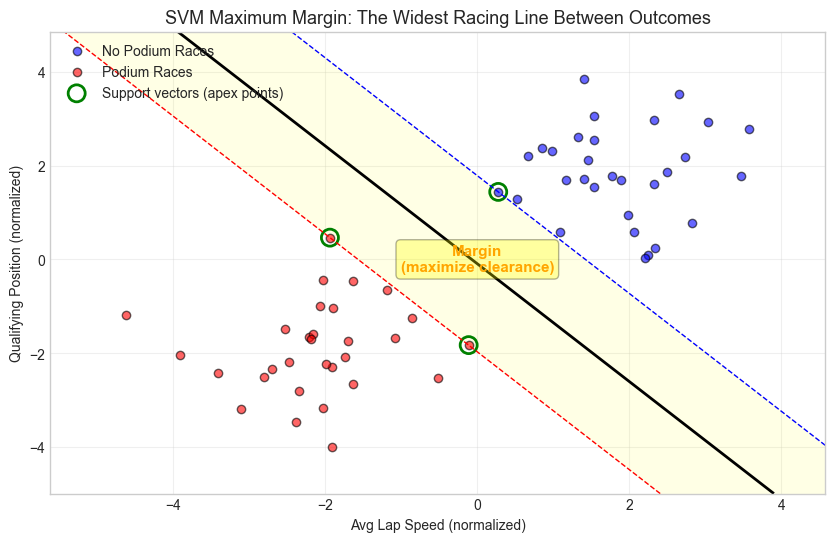

Solid black line: optimal racing line (decision boundary)
Dashed lines: kerbs on either side (margin boundaries)
Yellow region: the margin — the SVM maximizes this clearance
Number of support vectors: 3 out of 60 total races


In [10]:
# Visualize the margin concept — the optimal racing line with maximum clearance
np.random.seed(42)
X_simple = np.vstack([
    np.random.randn(30, 2) + np.array([2, 2]),
    np.random.randn(30, 2) + np.array([-2, -2])
])
y_simple = np.array([0]*30 + [1]*30)

svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X_simple, y_simple)

plt.figure(figsize=(10, 6))

# Decision boundary and margins
x_min, x_max = X_simple[:, 0].min() - 1, X_simple[:, 0].max() + 1
y_min, y_max = X_simple[:, 1].min() - 1, X_simple[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Get decision function values for margin visualization
Z = svm_linear.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'],
            linestyles=['--', '-', '--'], linewidths=[1, 2, 1])
plt.contourf(xx, yy, Z, levels=[-1, 1], alpha=0.1, colors=['yellow'])

plt.scatter(X_simple[y_simple==0, 0], X_simple[y_simple==0, 1], c='blue', edgecolors='k', alpha=0.6, label='No Podium Races')
plt.scatter(X_simple[y_simple==1, 0], X_simple[y_simple==1, 1], c='red', edgecolors='k', alpha=0.6, label='Podium Races')
plt.scatter(X_simple[svm_linear.support_, 0], X_simple[svm_linear.support_, 1],
            s=150, facecolors='none', edgecolors='green', linewidths=2, label='Support vectors (apex points)')

plt.xlabel('Avg Lap Speed (normalized)')
plt.ylabel('Qualifying Position (normalized)')
plt.title('SVM Maximum Margin: The Widest Racing Line Between Outcomes', fontsize=13)
plt.legend()
plt.grid(True, alpha=0.3)

plt.annotate('Margin\n(maximize clearance)', xy=(0, 0), fontsize=11,
             ha='center', va='center', color='orange', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.show()

print("Solid black line: optimal racing line (decision boundary)")
print("Dashed lines: kerbs on either side (margin boundaries)")
print("Yellow region: the margin — the SVM maximizes this clearance")
print(f"Number of support vectors: {len(svm_linear.support_)} out of {len(y_simple)} total races")

### Deep Dive: Why SVMs Matter for Deep Learning

SVMs introduce concepts that recur throughout deep learning:

| SVM Concept | Deep Learning Connection | F1 Parallel |
|-------------|-------------------------|-------------|
| Maximum margin | Contrastive learning maximizes distance between embeddings | Maximizing gap between winning and losing strategies |
| Kernel trick | Neural networks learn nonlinear feature mappings automatically | Transforming raw telemetry into meaningful race features |
| Support vectors | Hard examples in curriculum learning / hard negative mining | The marginal races that define the boundary between podium and midfield |
| Hinge loss | Still used in some architectures (e.g., face verification) | Penalty for crossing the racing line |
| Feature scaling | Batch normalization, layer normalization | Normalizing tire temps (100C) and fuel load (110kg) to comparable scales |

**The kernel trick was revolutionary** because it showed you could work in infinite-dimensional spaces efficiently. Neural networks took a different approach: instead of a fixed kernel, they *learn* the feature mapping from data. But the core insight — transform the data until the problem becomes linear — is the same.

---

## 4. Clustering

### Intuitive Explanation

Clustering is **unsupervised learning** — there are no labels, and the algorithm must discover structure on its own. The goal: group similar data points together.

Think of it like sorting all 24 F1 circuits without any predefined categories. You'd naturally group them by characteristics — street circuits (Monaco, Singapore, Baku), high-speed power tracks (Monza, Spa, Silverstone), technical slow-speed circuits (Hungary, Barcelona). Clustering algorithms do exactly this, but with numerical features instead of intuition.

| Algorithm | How It Works | Shape of Clusters | F1 Parallel |
|-----------|-------------|-------------------|-------------|
| **k-Means** | Iteratively assign points to nearest center, update centers | Spherical/convex | Grouping circuits by average speed + number of corners |
| **DBSCAN** | Group points in dense regions, mark sparse points as noise | Arbitrary shapes | Finding natural circuit clusters regardless of shape, flagging outliers like Monaco |

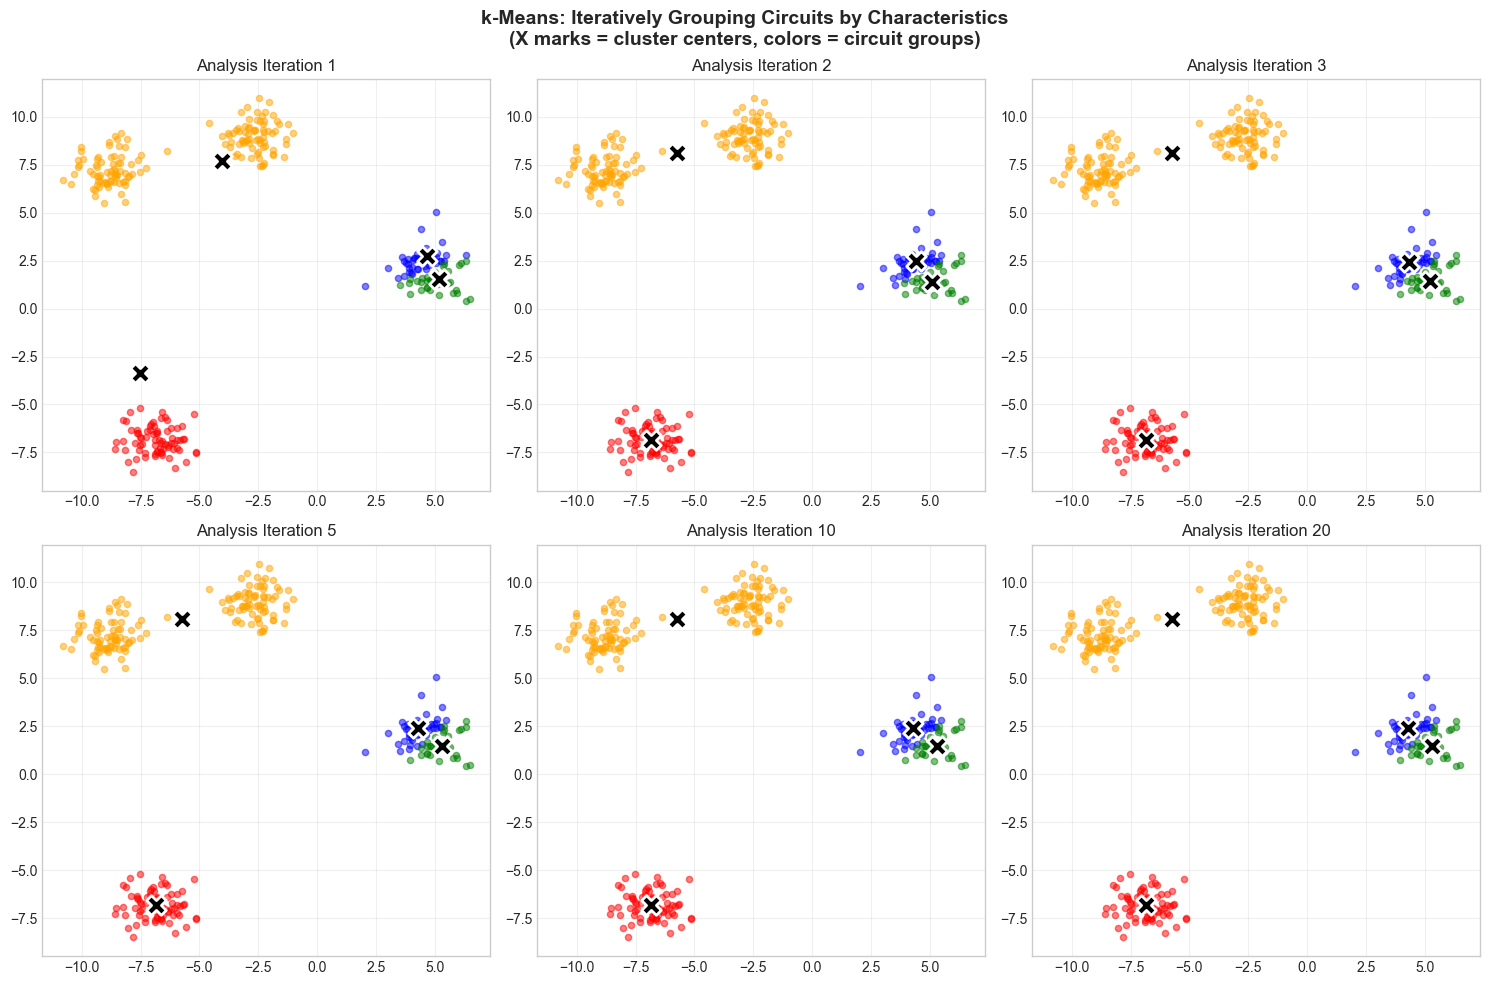

k-Means algorithm (like iteratively refining circuit categories):
1. Start with K random 'prototype' circuits
2. Assign each circuit to its most similar prototype
3. Move each prototype to the center of its assigned circuits
4. Repeat steps 2-3 until the groupings stabilize


In [11]:
# k-Means: Grouping circuits by characteristics — iterative convergence
X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, cluster_std=0.8, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Manual k-means iterations to show the process
from sklearn.cluster import KMeans as KM

# Initialize with random centroids
np.random.seed(42)
initial_centers = X_blobs[np.random.choice(len(X_blobs), 4, replace=False)]

# Show iterations — like refining circuit classifications over multiple analyses
colors = ['blue', 'red', 'green', 'orange']
circuit_types = ['Power Tracks', 'Street Circuits', 'Technical', 'Mixed']
iterations = [1, 2, 3, 5, 10, 20]

for idx, max_iter in enumerate(iterations):
    row, col = idx // 3, idx % 3
    
    km = KMeans(n_clusters=4, init=initial_centers, n_init=1, max_iter=max_iter, random_state=42)
    labels = km.fit_predict(X_blobs)
    centers = km.cluster_centers_
    
    for k in range(4):
        mask = labels == k
        axes[row, col].scatter(X_blobs[mask, 0], X_blobs[mask, 1], 
                               c=colors[k], alpha=0.5, s=20)
    
    axes[row, col].scatter(centers[:, 0], centers[:, 1], c='black', marker='X', 
                           s=200, edgecolors='white', linewidths=2, zorder=5)
    axes[row, col].set_title(f'Analysis Iteration {max_iter}')
    axes[row, col].grid(True, alpha=0.3)

plt.suptitle('k-Means: Iteratively Grouping Circuits by Characteristics\n'
             '(X marks = cluster centers, colors = circuit groups)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("k-Means algorithm (like iteratively refining circuit categories):")
print("1. Start with K random 'prototype' circuits")
print("2. Assign each circuit to its most similar prototype")
print("3. Move each prototype to the center of its assigned circuits")
print("4. Repeat steps 2-3 until the groupings stabilize")

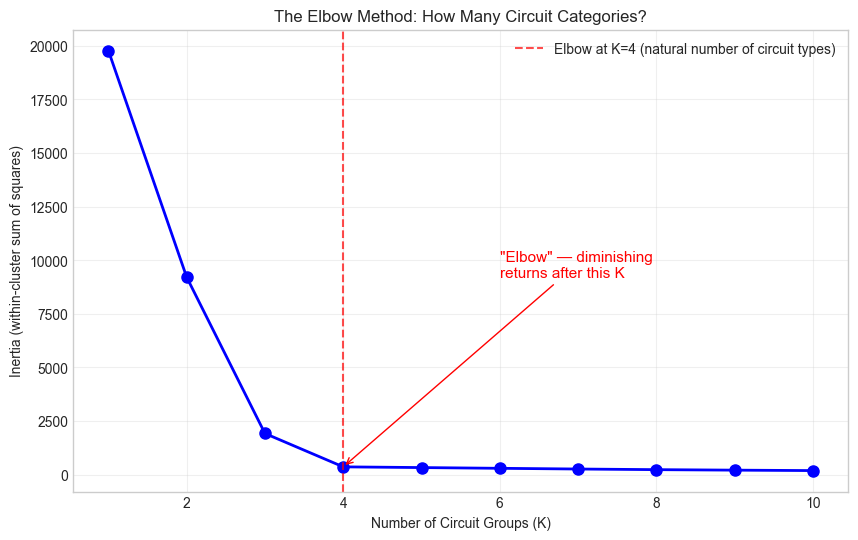

The elbow method: plot inertia vs K and look for the 'bend'.
Before the elbow: adding groups gives big improvement (splitting 'power tracks' from 'street circuits').
After the elbow: adding groups gives diminishing returns (splitting 'slightly twisty' from 'very twisty').

Inertia values: ['19780', '9211', '1919', '362', '329', '295', '262', '232', '209', '189']


In [12]:
# Elbow Method: How many circuit categories should we use?
inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_blobs)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Elbow at K=4 (natural number of circuit types)')
plt.xlabel('Number of Circuit Groups (K)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('The Elbow Method: How Many Circuit Categories?')
plt.legend()
plt.grid(True, alpha=0.3)

plt.annotate('"Elbow" — diminishing\nreturns after this K',
             xy=(4, inertias[3]), xytext=(6, inertias[1]),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=11, color='red')

plt.show()

print("The elbow method: plot inertia vs K and look for the 'bend'.")
print("Before the elbow: adding groups gives big improvement (splitting 'power tracks' from 'street circuits').")
print("After the elbow: adding groups gives diminishing returns (splitting 'slightly twisty' from 'very twisty').")
print(f"\nInertia values: {[f'{x:.0f}' for x in inertias]}")

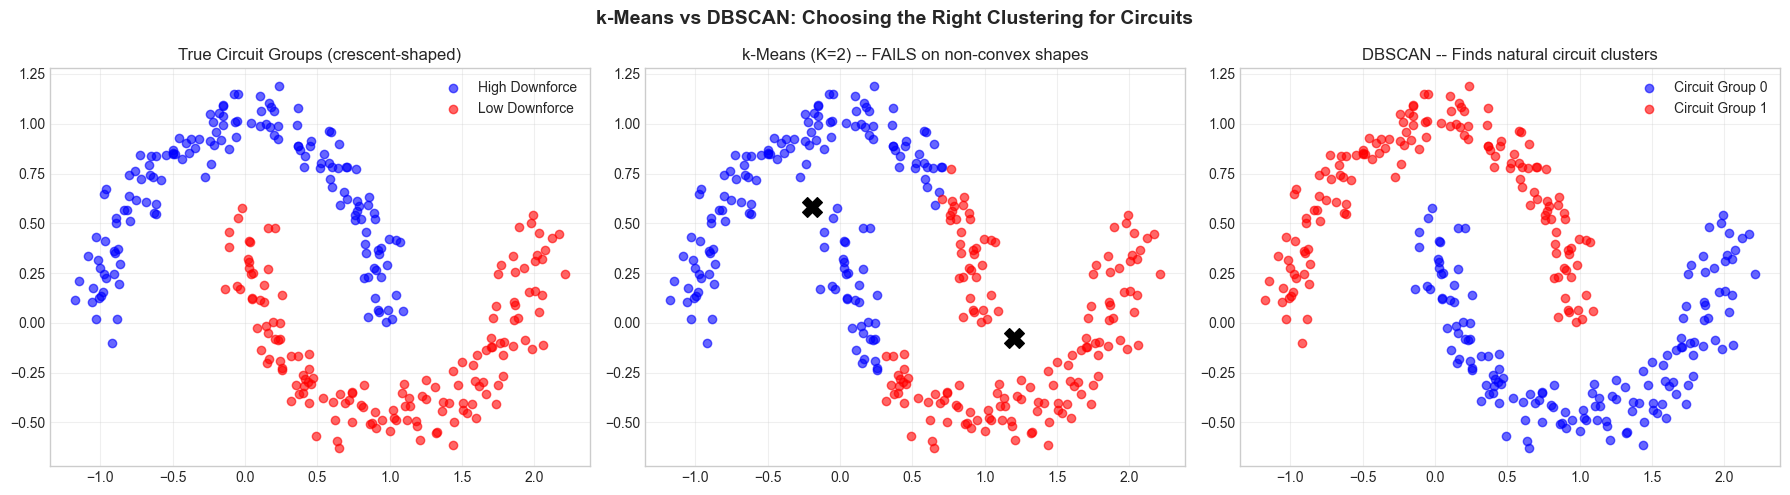

k-Means assumes spherical clusters — it fails on crescent-shaped circuit data.
DBSCAN finds clusters of arbitrary shape by following dense regions.
DBSCAN also detects outlier circuits (gray X) that don't fit any group — like Monaco!


In [13]:
# k-Means vs DBSCAN: Different approaches to circuit classification
# Create data with non-convex clusters — like circuits that share complex characteristics
X_circles, y_circles = make_moons(n_samples=300, noise=0.08, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# True labels
axes[0].scatter(X_circles[y_circles==0, 0], X_circles[y_circles==0, 1], c='blue', alpha=0.6, label='High Downforce')
axes[0].scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], c='red', alpha=0.6, label='Low Downforce')
axes[0].set_title('True Circuit Groups (crescent-shaped)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# k-Means (fails on non-convex — like trying to force street circuits into round categories)
km = KMeans(n_clusters=2, random_state=42, n_init=10)
km_labels = km.fit_predict(X_circles)
axes[1].scatter(X_circles[km_labels==0, 0], X_circles[km_labels==0, 1], c='blue', alpha=0.6)
axes[1].scatter(X_circles[km_labels==1, 0], X_circles[km_labels==1, 1], c='red', alpha=0.6)
axes[1].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='black', marker='X', s=200, zorder=5)
axes[1].set_title('k-Means (K=2) -- FAILS on non-convex shapes')
axes[1].grid(True, alpha=0.3)

# DBSCAN (handles non-convex — finds natural groupings regardless of shape)
db = DBSCAN(eps=0.2, min_samples=5)
db_labels = db.fit_predict(X_circles)
for label in np.unique(db_labels):
    if label == -1:
        axes[2].scatter(X_circles[db_labels==label, 0], X_circles[db_labels==label, 1], 
                       c='gray', marker='x', alpha=0.5, label='Outlier Circuits')
    else:
        color = ['blue', 'red', 'green'][label % 3]
        axes[2].scatter(X_circles[db_labels==label, 0], X_circles[db_labels==label, 1], 
                       c=color, alpha=0.6, label=f'Circuit Group {label}')
axes[2].set_title('DBSCAN -- Finds natural circuit clusters')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('k-Means vs DBSCAN: Choosing the Right Clustering for Circuits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("k-Means assumes spherical clusters — it fails on crescent-shaped circuit data.")
print("DBSCAN finds clusters of arbitrary shape by following dense regions.")
print("DBSCAN also detects outlier circuits (gray X) that don't fit any group — like Monaco!")

### Deep Dive: Clustering in the ML Pipeline

Clustering isn't just an end in itself — it's a tool used throughout ML and has direct F1 applications:

| Application | How Clustering Is Used | F1 Parallel |
|-------------|----------------------|-------------|
| **Feature engineering** | Cluster IDs become features for downstream models | Circuit type as a feature for lap time prediction |
| **Data exploration** | Discover natural groups before building supervised models | Finding which races share similar characteristics |
| **Anomaly detection** | Points far from any cluster center are anomalies | Detecting mechanical failures from outlier telemetry |
| **Semi-supervised learning** | Propagate labels from labeled to unlabeled points in same cluster | Applying known setup insights to similar unlabeled circuits |
| **Embeddings** | k-means on word embeddings discovers topic clusters | Grouping driver styles from performance embeddings |
| **Vector quantization** | Compress continuous embeddings to discrete cluster IDs (used in VQ-VAE) | Discretizing continuous telemetry into strategy states |

---

## 5. k-Nearest Neighbors and Naive Bayes

### k-Nearest Neighbors (k-NN)

The simplest classifier: to predict a new point, find the K closest training points and take a majority vote. In F1 terms: to predict the result of an upcoming race, find the K most similar historical races and see what happened.

**Strengths:** No training phase, works for any number of classes, intuitive.  
**Weaknesses:** Slow at prediction time (must compare to all training points), sensitive to feature scales, struggles in high dimensions ("curse of dimensionality").

### Naive Bayes

Uses Bayes' theorem with the "naive" assumption that features are independent:

$$P(y \mid x_1, x_2, \ldots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)$$

**F1 analogy**: Estimating the probability of a podium finish given weather, tire choice, and qualifying position — but assuming each factor is independent (a "naive" assumption, since tire choice clearly depends on weather).

**Strengths:** Extremely fast, works well with high-dimensional sparse data (text), good with small training sets.  
**Weaknesses:** The independence assumption is almost never true, so probability estimates are often poorly calibrated.

| Algorithm | Type | Training | Prediction | F1 Use Case |
|-----------|------|----------|------------|-------------|
| **k-NN** | Distance-based | None (stores data) | Slow (O(n) per query) | "Find me the 5 most similar past races to predict this one" |
| **Naive Bayes** | Probabilistic | Fast (O(n*d)) | Very fast (O(d)) | Quick probability estimates from independent factors |

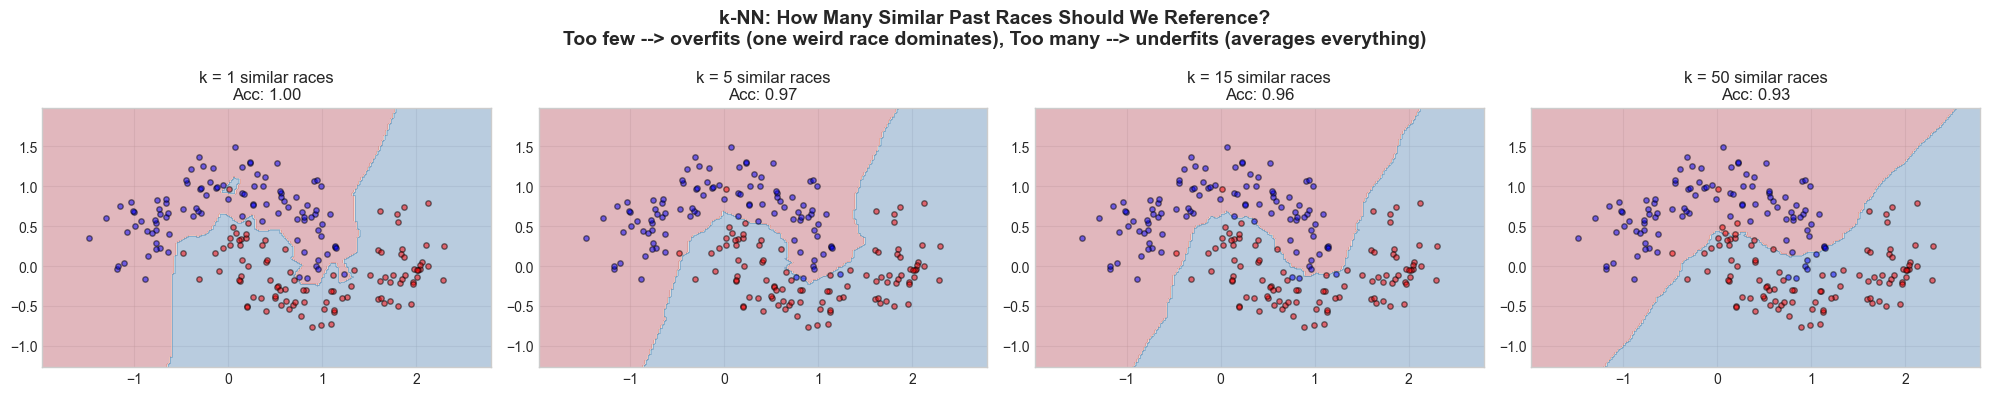

k=1: One similar race decides everything (overfitting — one anomalous race skews all)
k=50: Too many races averaged out (underfitting — loses signal in the noise)
k=5 or k=15: Good balance — enough races for reliability, few enough to stay relevant


In [14]:
# k-NN: How many similar races should we consider?
X_knn, y_knn = make_moons(n_samples=200, noise=0.2, random_state=42)

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

x_min, x_max = X_knn[:, 0].min() - 0.5, X_knn[:, 0].max() + 0.5
y_min, y_max = X_knn[:, 1].min() - 0.5, X_knn[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

for idx, k in enumerate([1, 5, 15, 50]):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_knn, y_knn)
    
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
    axes[idx].scatter(X_knn[y_knn==0, 0], X_knn[y_knn==0, 1], c='blue', edgecolors='k', alpha=0.5, s=15)
    axes[idx].scatter(X_knn[y_knn==1, 0], X_knn[y_knn==1, 1], c='red', edgecolors='k', alpha=0.5, s=15)
    axes[idx].set_title(f'k = {k} similar races\nAcc: {knn.score(X_knn, y_knn):.2f}')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('k-NN: How Many Similar Past Races Should We Reference?\n'
             'Too few --> overfits (one weird race dominates), Too many --> underfits (averages everything)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("k=1: One similar race decides everything (overfitting — one anomalous race skews all)")
print("k=50: Too many races averaged out (underfitting — loses signal in the noise)")
print("k=5 or k=15: Good balance — enough races for reliability, few enough to stay relevant")

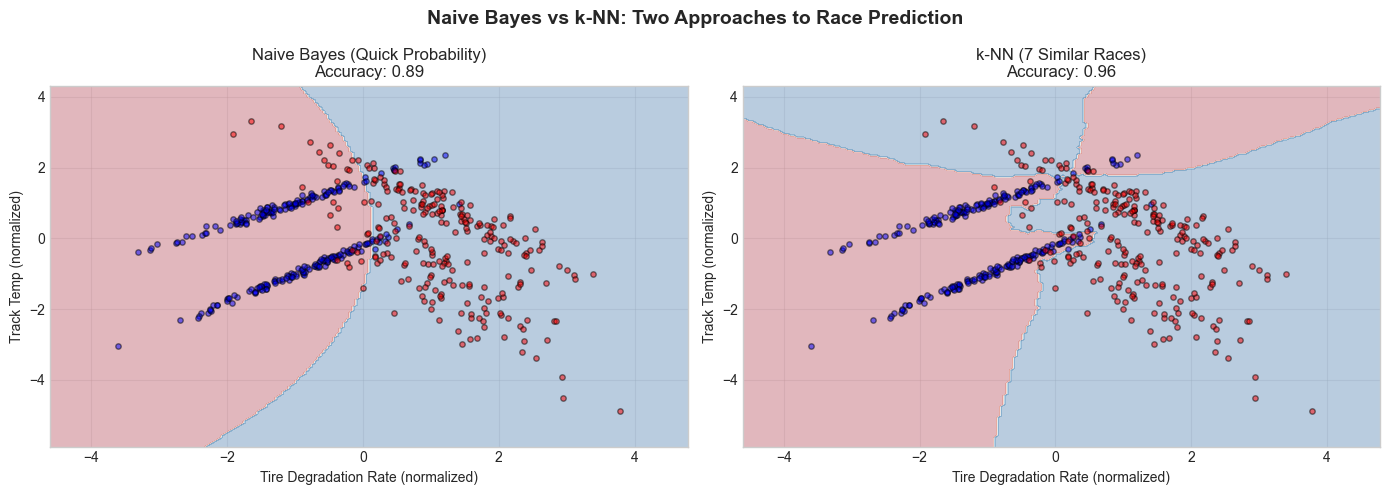

Naive Bayes: smooth boundary (assumes independent Gaussian features)
k-NN: flexible, adapts to local patterns in historical data

Both are useful baselines — always try simple models first!


In [15]:
# Naive Bayes vs k-NN: Probabilistic vs Distance-Based race prediction
X_compare, y_compare = make_classification(n_samples=500, n_features=2, n_redundant=0,
                                            n_informative=2, n_clusters_per_class=2, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_min, x_max = X_compare[:, 0].min() - 1, X_compare[:, 0].max() + 1
y_min, y_max = X_compare[:, 1].min() - 1, X_compare[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Naive Bayes — quick probabilistic estimate
nb = GaussianNB()
nb.fit(X_compare, y_compare)
Z = nb.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[0].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
axes[0].scatter(X_compare[y_compare==0, 0], X_compare[y_compare==0, 1], c='blue', edgecolors='k', alpha=0.5, s=15)
axes[0].scatter(X_compare[y_compare==1, 0], X_compare[y_compare==1, 1], c='red', edgecolors='k', alpha=0.5, s=15)
axes[0].set_title(f'Naive Bayes (Quick Probability)\nAccuracy: {nb.score(X_compare, y_compare):.2f}')
axes[0].set_xlabel('Tire Degradation Rate (normalized)')
axes[0].set_ylabel('Track Temp (normalized)')
axes[0].grid(True, alpha=0.3)

# k-NN — find similar historic races
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_compare, y_compare)
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[1].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
axes[1].scatter(X_compare[y_compare==0, 0], X_compare[y_compare==0, 1], c='blue', edgecolors='k', alpha=0.5, s=15)
axes[1].scatter(X_compare[y_compare==1, 0], X_compare[y_compare==1, 1], c='red', edgecolors='k', alpha=0.5, s=15)
axes[1].set_title(f'k-NN (7 Similar Races)\nAccuracy: {knn.score(X_compare, y_compare):.2f}')
axes[1].set_xlabel('Tire Degradation Rate (normalized)')
axes[1].set_ylabel('Track Temp (normalized)')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Naive Bayes vs k-NN: Two Approaches to Race Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Naive Bayes: smooth boundary (assumes independent Gaussian features)")
print("k-NN: flexible, adapts to local patterns in historical data")
print("\nBoth are useful baselines — always try simple models first!")

---

## 6. Model Evaluation

### Intuitive Explanation

Training accuracy is meaningless if the model memorizes the data. We need to evaluate on data the model has **never seen**. In F1 terms: a setup that looks perfect in the simulator is worthless unless it translates to real track performance. This section covers the essential toolkit for honest model evaluation.

### Cross-Validation

Instead of a single train/test split (which depends on which races ended up in which set), **k-fold cross-validation** rotates through K different splits and averages the results:

1. Split your historical race data into K groups of races
2. For each group: train on K-1 groups, test on the held-out group
3. Average the K test scores

**What this means:** Cross-validation is like testing your strategy model across different race weekends — not just the ones you trained on. It gives a more reliable estimate of how your model will perform at the next Grand Prix.

### The Confusion Matrix

For classification, accuracy alone is not enough. The confusion matrix breaks down predictions into four categories:

|  | Predicted Podium | Predicted No Podium |
|--|-----------------|---------------------|
| **Actually Podium** | True Positive (TP) | False Negative (FN) |
| **Actually No Podium** | False Positive (FP) | True Negative (TN) |

From this matrix, we derive:

| Metric | Formula | Intuition | F1 Racing Parallel |
|--------|---------|-----------|-------------------|
| **Accuracy** | (TP+TN) / Total | Overall correctness | % of race outcomes predicted correctly |
| **Precision** | TP / (TP+FP) | "Of predicted podiums, how many actually happened?" | Don't cry wolf — only predict podium when confident |
| **Recall** | TP / (TP+FN) | "Of actual podiums, how many did we predict?" | Don't miss a podium opportunity |
| **F1 Score** | 2 * (P*R) / (P+R) | Harmonic mean of precision and recall | The **F1 score in F1 racing** — yes, the naming coincidence is delightful! |

Strategy Model               CV Mean     CV Std Worst Race  Best Race
----------------------------------------------------------------------


Decision Tree                 0.8660     0.0136     0.8400     0.8800


Random Forest                 0.9100     0.0303     0.8600     0.9400


Gradient Boosting             0.9160     0.0206     0.8900     0.9400
SVM (RBF)                     0.9120     0.0293     0.8800     0.9500
k-NN (k=5)                    0.8980     0.0214     0.8700     0.9300
Naive Bayes                   0.8180     0.0560     0.7200     0.8600


/var/folders/l3/qp293kmd0ps5v659jn3njrpc0000gn/T/ipykernel_2531/627549163.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([scores for scores in cv_results.values()], labels=cv_results.keys(),


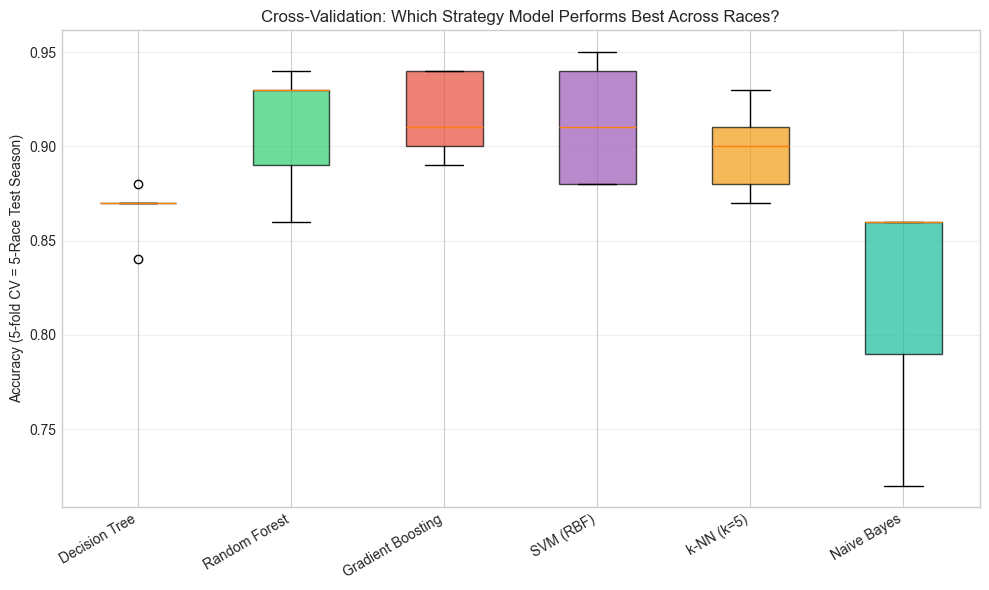

In [16]:
# Cross-validation comparison: testing all strategy models across multiple race weekends
X_eval, y_eval = make_classification(n_samples=500, n_features=10, n_informative=5,
                                      n_redundant=2, random_state=42)

models_eval = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
}

print(f"{'Strategy Model':<25} {'CV Mean':>10} {'CV Std':>10} {'Worst Race':>10} {'Best Race':>10}")
print('-' * 70)

cv_results = {}
for name, model in models_eval.items():
    scores = cross_val_score(model, X_eval, y_eval, cv=5, scoring='accuracy')
    cv_results[name] = scores
    print(f"{name:<25} {scores.mean():>10.4f} {scores.std():>10.4f} {scores.min():>10.4f} {scores.max():>10.4f}")

# Visualize — like comparing model performance across a 5-race test season
plt.figure(figsize=(10, 6))
positions = range(len(cv_results))
bp = plt.boxplot([scores for scores in cv_results.values()], labels=cv_results.keys(),
                  patch_artist=True)

colors_box = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Accuracy (5-fold CV = 5-Race Test Season)')
plt.title('Cross-Validation: Which Strategy Model Performs Best Across Races?')
plt.xticks(rotation=30, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

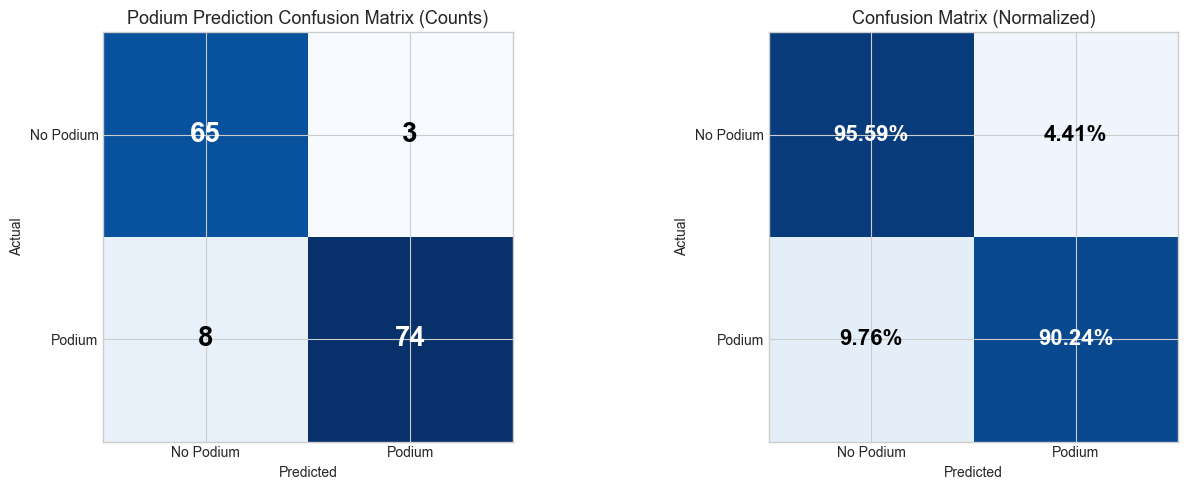


Podium Prediction Report:
              precision    recall  f1-score   support

   No Podium       0.89      0.96      0.92        68
      Podium       0.96      0.90      0.93        82

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



In [17]:
# Confusion Matrix: How well does our podium predictor work?
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(
    X_eval, y_eval, test_size=0.3, random_state=42)

# Train a Random Forest podium predictor
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_eval, y_train_eval)
y_pred = rf.predict(X_test_eval)

# Confusion matrix
cm = confusion_matrix(y_test_eval, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
im = axes[0].imshow(cm, interpolation='nearest', cmap='Blues')
axes[0].set_title('Podium Prediction Confusion Matrix (Counts)', fontsize=13)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['No Podium', 'Podium'])
axes[0].set_yticklabels(['No Podium', 'Podium'])

# Add text annotations
for i in range(2):
    for j in range(2):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        axes[0].text(j, i, f'{cm[i, j]}', ha='center', va='center', 
                    fontsize=20, color=text_color, fontweight='bold')

# Normalized (percentages)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im2 = axes[1].imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=13)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['No Podium', 'Podium'])
axes[1].set_yticklabels(['No Podium', 'Podium'])

for i in range(2):
    for j in range(2):
        text_color = 'white' if cm_norm[i, j] > 0.5 else 'black'
        axes[1].text(j, i, f'{cm_norm[i, j]:.2%}', ha='center', va='center', 
                    fontsize=16, color=text_color, fontweight='bold')

plt.tight_layout()
plt.show()

# Classification report — including that delightful F1 score!
print("\nPodium Prediction Report:")
print(classification_report(y_test_eval, y_pred, target_names=['No Podium', 'Podium']))

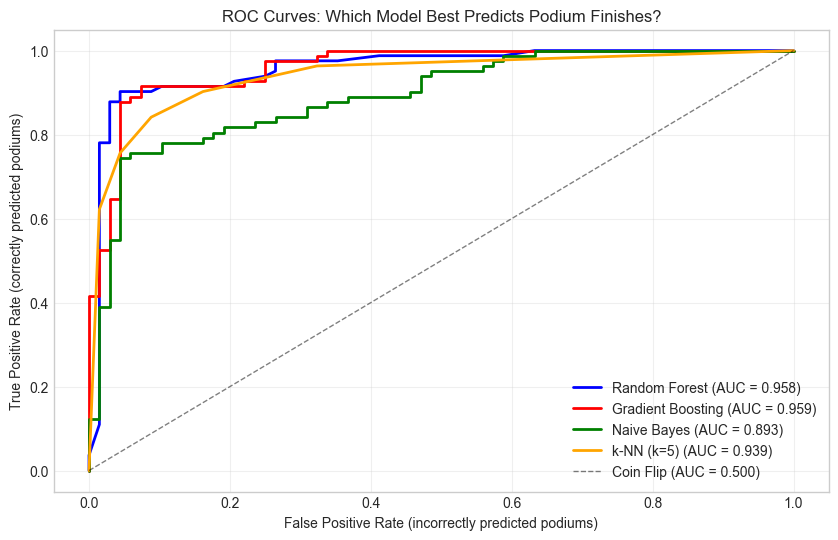

Reading ROC curves:
- Upper-left corner is the perfect oracle strategist (catches every podium, no false alarms)
- Diagonal line = flipping a coin to predict podiums
- AUC (Area Under Curve): 1.0 = perfect, 0.5 = random
- Higher AUC = better at distinguishing podium races from the rest


In [18]:
# ROC Curves: Comparing race prediction models — who calls it best?
# Need probability outputs, so we use models that support predict_proba
roc_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
}

plt.figure(figsize=(10, 6))

colors_roc = ['blue', 'red', 'green', 'orange']
for (name, model), color in zip(roc_models.items(), colors_roc):
    model.fit(X_train_eval, y_train_eval)
    y_prob = model.predict_proba(X_test_eval)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_eval, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Random baseline — a coin-flip predictor
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Coin Flip (AUC = 0.500)')

plt.xlabel('False Positive Rate (incorrectly predicted podiums)')
plt.ylabel('True Positive Rate (correctly predicted podiums)')
plt.title('ROC Curves: Which Model Best Predicts Podium Finishes?')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

print("Reading ROC curves:")
print("- Upper-left corner is the perfect oracle strategist (catches every podium, no false alarms)")
print("- Diagonal line = flipping a coin to predict podiums")
print("- AUC (Area Under Curve): 1.0 = perfect, 0.5 = random")
print("- Higher AUC = better at distinguishing podium races from the rest")

### Deep Dive: When to Use What Metric

Choosing the right metric is one of the most important — and most overlooked — decisions in ML. Just like in F1, where the right success metric depends on the situation:

| Scenario | Best Metric | F1 Racing Parallel |
|----------|------------|-------------------|
| Balanced classes, equal costs | **Accuracy** | Overall race prediction accuracy when podiums and non-podiums are equally common |
| Imbalanced classes | **F1 Score** or **AUC-ROC** | Predicting Safety Cars (rare events) — accuracy is misleading |
| Cost of false alarm is high | **Precision** | Pitting for rain that never comes (false positive = lost track position) |
| Cost of missing is high | **Recall** | Missing a safety car opportunity to pit (false negative = missed advantage) |
| Ranking/recommendation | **AUC-ROC** | Ranking drivers by championship likelihood (ordering matters, not threshold) |
| Information retrieval | **Precision@K** | Finding the top K similar circuits for setup transfer |

#### Common Misconceptions

| Misconception | Reality |
|---------------|--------|
| High accuracy = good model | On imbalanced data, always predicting "no safety car" gives 95% accuracy but is useless |
| AUC-ROC is always best | AUC-ROC can be misleading with severe class imbalance; use Precision-Recall AUC instead |
| One metric tells the whole story | Always look at multiple metrics — like how F1 uses points, wins, AND poles to evaluate drivers |

---

## 7. When NOT to Use Deep Learning

### Practical Decision Guide

Deep learning is powerful but not always the right tool. Classical ML wins in many real-world scenarios — and F1 is a great example. Most of the data on the pit wall is tabular (telemetry readings, tire data, weather forecasts), and classical ML handles tabular data better.

/Users/danshah/claude_projects/learning/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/Users/danshah/claude_projects/learning/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


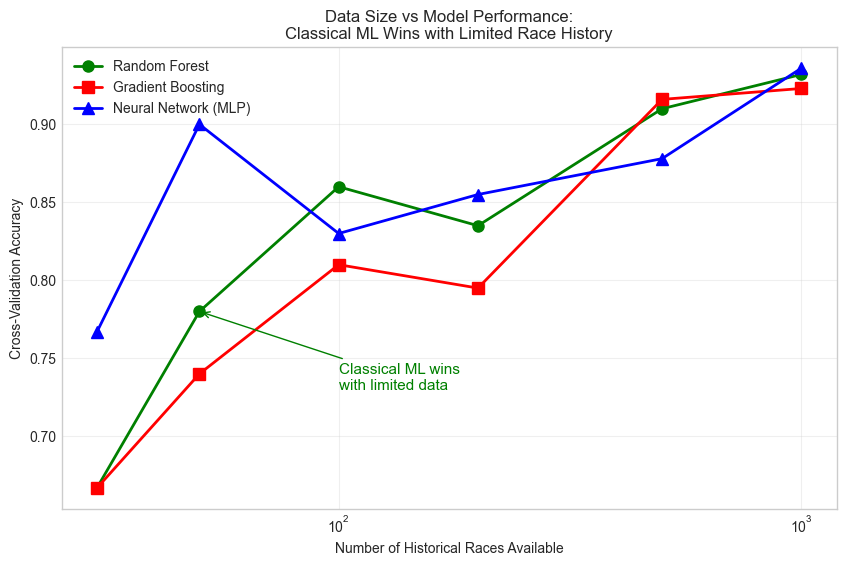

Key insight: With fewer than ~200 historical races, Random Forests and Gradient
Boosting typically outperform neural networks. F1 teams often have limited
data (20-23 races per season) — which is exactly where classical ML excels.


In [19]:
# Demonstration: Small data — where classical ML shines
# Like predicting race outcomes with only a few seasons of data
from sklearn.neural_network import MLPClassifier

sample_sizes = [30, 50, 100, 200, 500, 1000]
results_rf = []
results_gb = []
results_nn = []

for n_samples in sample_sizes:
    # Generate race data (varying amounts of historical races)
    X_size, y_size = make_classification(n_samples=n_samples, n_features=10, 
                                         n_informative=5, n_redundant=2, random_state=42)
    
    # Random Forest (strategy team)
    rf_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), 
                                X_size, y_size, cv=5)
    results_rf.append(rf_scores.mean())
    
    # Gradient Boosting (debrief loop)
    gb_scores = cross_val_score(GradientBoostingClassifier(n_estimators=100, random_state=42),
                                X_size, y_size, cv=5)
    results_gb.append(gb_scores.mean())
    
    # Neural Network (deep learning approach)
    nn_scores = cross_val_score(MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=500, 
                                              random_state=42),
                                X_size, y_size, cv=5)
    results_nn.append(nn_scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, results_rf, 'g-o', linewidth=2, markersize=8, label='Random Forest')
plt.plot(sample_sizes, results_gb, 'r-s', linewidth=2, markersize=8, label='Gradient Boosting')
plt.plot(sample_sizes, results_nn, 'b-^', linewidth=2, markersize=8, label='Neural Network (MLP)')

plt.xlabel('Number of Historical Races Available')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Data Size vs Model Performance:\nClassical ML Wins with Limited Race History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.annotate('Classical ML wins\nwith limited data', xy=(50, results_rf[1]), xytext=(100, results_rf[1] - 0.05),
             arrowprops=dict(arrowstyle='->', color='green'),
             fontsize=11, color='green')

plt.show()

print("Key insight: With fewer than ~200 historical races, Random Forests and Gradient")
print("Boosting typically outperform neural networks. F1 teams often have limited")
print("data (20-23 races per season) — which is exactly where classical ML excels.")

### The Decision Framework

| Situation | Use Classical ML | Use Deep Learning | F1 Example |
|-----------|-----------------|------------------|------------|
| **Data size** | < 10K samples | > 100K samples | Few seasons of race data vs. millions of telemetry samples |
| **Data type** | Tabular (rows and columns) | Images, text, audio, video | Pit wall spreadsheets vs. onboard camera footage |
| **Features** | Hand-crafted, meaningful | Raw pixels, tokens, waveforms | Tire wear %, fuel load, gap to leader vs. raw sensor streams |
| **Interpretability** | Required (medical, legal, finance) | Not critical | Explaining strategy calls to the team principal |
| **Training budget** | Minutes on a laptop | Hours/days on GPUs | Real-time strategy updates during a race |
| **Deployment** | Edge devices, low latency | Server-side, batch processing | In-car systems vs. factory simulations |
| **Baseline** | ALWAYS start here | After classical ML baseline | Every model must beat a simple baseline |

### The Real-World Truth About Tabular Data

As of 2024, **gradient boosted trees (XGBoost, LightGBM, CatBoost) still outperform deep learning on most tabular datasets**. This is a well-studied phenomenon — and it's why F1 teams lean heavily on tree-based models for telemetry analysis:

1. Tabular data has **heterogeneous features** (mix of types, scales, meanings — tire temp in Celsius, fuel load in kg, wind speed in km/h)
2. Tree-based models handle this naturally; neural nets need careful preprocessing
3. Trees are **rotation-invariant** to individual features; neural nets are not
4. Tabular datasets are typically smaller, favoring classical ML

**Rule of thumb:** If your data fits in a spreadsheet — like a race engineer's telemetry dashboard — try XGBoost before reaching for a neural network.

---

## Exercises

### Exercise 1: Build a Race Outcome Prediction Pipeline

You're the data scientist at a mid-grid F1 team. Create a function that takes historical race data (features like tire wear, fuel load, qualifying position, etc.) and compares multiple classifiers to find the best predictor for podium finishes. Return the best model.

In [20]:
# EXERCISE 1: Race outcome prediction pipeline
def find_best_race_predictor(X, y, cv=5):
    """
    Compare multiple classifiers on historical race data and return the best predictor.
    
    Args:
        X: Feature matrix (race telemetry: tire wear, fuel, quali pos, etc.)
        y: Labels (1 = podium finish, 0 = no podium)
        cv: Number of cross-validation folds (like testing across different race weekends)
    
    Returns:
        Tuple of (best_model_name, best_cv_score, results_dict)
        where results_dict maps model names to their mean CV scores
    """
    # TODO: Implement this!
    # 1. Scale the features using StandardScaler (tire temp and fuel load have different units)
    # 2. Define a dictionary of at least 4 models (Decision Tree, Random Forest,
    #    Gradient Boosting, SVM, k-NN, Naive Bayes)
    # 3. Run cross_val_score for each model
    # 4. Return the name and score of the best model, plus all results
    # Hint: Use StandardScaler().fit_transform(X) to scale features
    
    pass


# Test with simulated race data
# Features: [quali_pos, tire_wear, fuel_load, track_temp, downforce, 
#            top_speed, sector1_time, sector2_time, pit_delta, wind_speed]
X_race, y_race = make_classification(n_samples=500, n_features=10, n_informative=5,
                                      n_redundant=2, random_state=42)

result = find_best_race_predictor(X_race, y_race)
if result is not None:
    best_name, best_score, all_results = result
    print(f"Best podium predictor: {best_name} (CV score: {best_score:.4f})")
    print(f"\nAll models ranked:")
    for name, score in sorted(all_results.items(), key=lambda x: x[1], reverse=True):
        print(f"  {name}: {score:.4f}")
    
    # Verify
    assert best_score > 0.80, f"Best score should be > 0.80, got {best_score:.4f}"
    assert len(all_results) >= 4, f"Should compare at least 4 models, got {len(all_results)}"
    print(f"\nAll checks passed!")
else:
    print("TODO: Implement find_best_race_predictor")

TODO: Implement find_best_race_predictor


### Exercise 2: Circuit Clustering Evaluation

Implement the **silhouette score** from scratch. You're evaluating how well your circuit clustering algorithm groups F1 tracks — the silhouette score measures how similar a circuit is to its own group vs the nearest neighboring group. It ranges from -1 (wrong group) to +1 (perfectly matched).

For each circuit $i$:
- $a(i)$ = average distance to all other circuits in the **same** group
- $b(i)$ = average distance to all circuits in the **nearest other** group
- $s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$

In [21]:
# EXERCISE 2: Silhouette score from scratch — evaluating circuit groupings
def silhouette_score_manual(X, labels):
    """
    Calculate the mean silhouette score for a circuit clustering.
    
    Args:
        X: Feature matrix (n_circuits, n_features) — e.g., avg speed, corners, elevation change
        labels: Cluster assignments for each circuit
    
    Returns:
        Mean silhouette score (float between -1 and 1)
    """
    # TODO: Implement this!
    # For each circuit i:
    #   1. Compute a(i): mean distance to circuits in same group
    #   2. Compute b(i): mean distance to circuits in nearest OTHER group
    #   3. Compute s(i) = (b(i) - a(i)) / max(a(i), b(i))
    # Return the mean of all s(i)
    # Hint: Use np.linalg.norm(X[i] - X[j]) for distance
    # Hint: Handle edge case where a group has only 1 circuit (s(i) = 0)
    
    pass


# Test with simulated circuit data
from sklearn.metrics import silhouette_score as sklearn_silhouette

# Simulate circuit features: [avg_speed, n_corners, elevation_change]
X_circuits, y_circuits = make_blobs(n_samples=150, centers=3, cluster_std=0.8, random_state=42)
km_circuits = KMeans(n_clusters=3, random_state=42, n_init=10)
circuit_groups = km_circuits.fit_predict(X_circuits)

manual_score = silhouette_score_manual(X_circuits, circuit_groups)
if manual_score is not None:
    sklearn_score = sklearn_silhouette(X_circuits, circuit_groups)
    print(f"Your silhouette score: {manual_score:.4f}")
    print(f"sklearn silhouette score: {sklearn_score:.4f}")
    print(f"Correct: {np.allclose(manual_score, sklearn_score, atol=1e-4)}")
else:
    print("TODO: Implement silhouette_score_manual")

TODO: Implement silhouette_score_manual


### Exercise 3: Race Strategy Decision Boundary Explorer

Create a function that plots the decision boundary of any sklearn classifier on 2D race data. Then use it to compare how different strategy models separate podium finishes from midfield results.

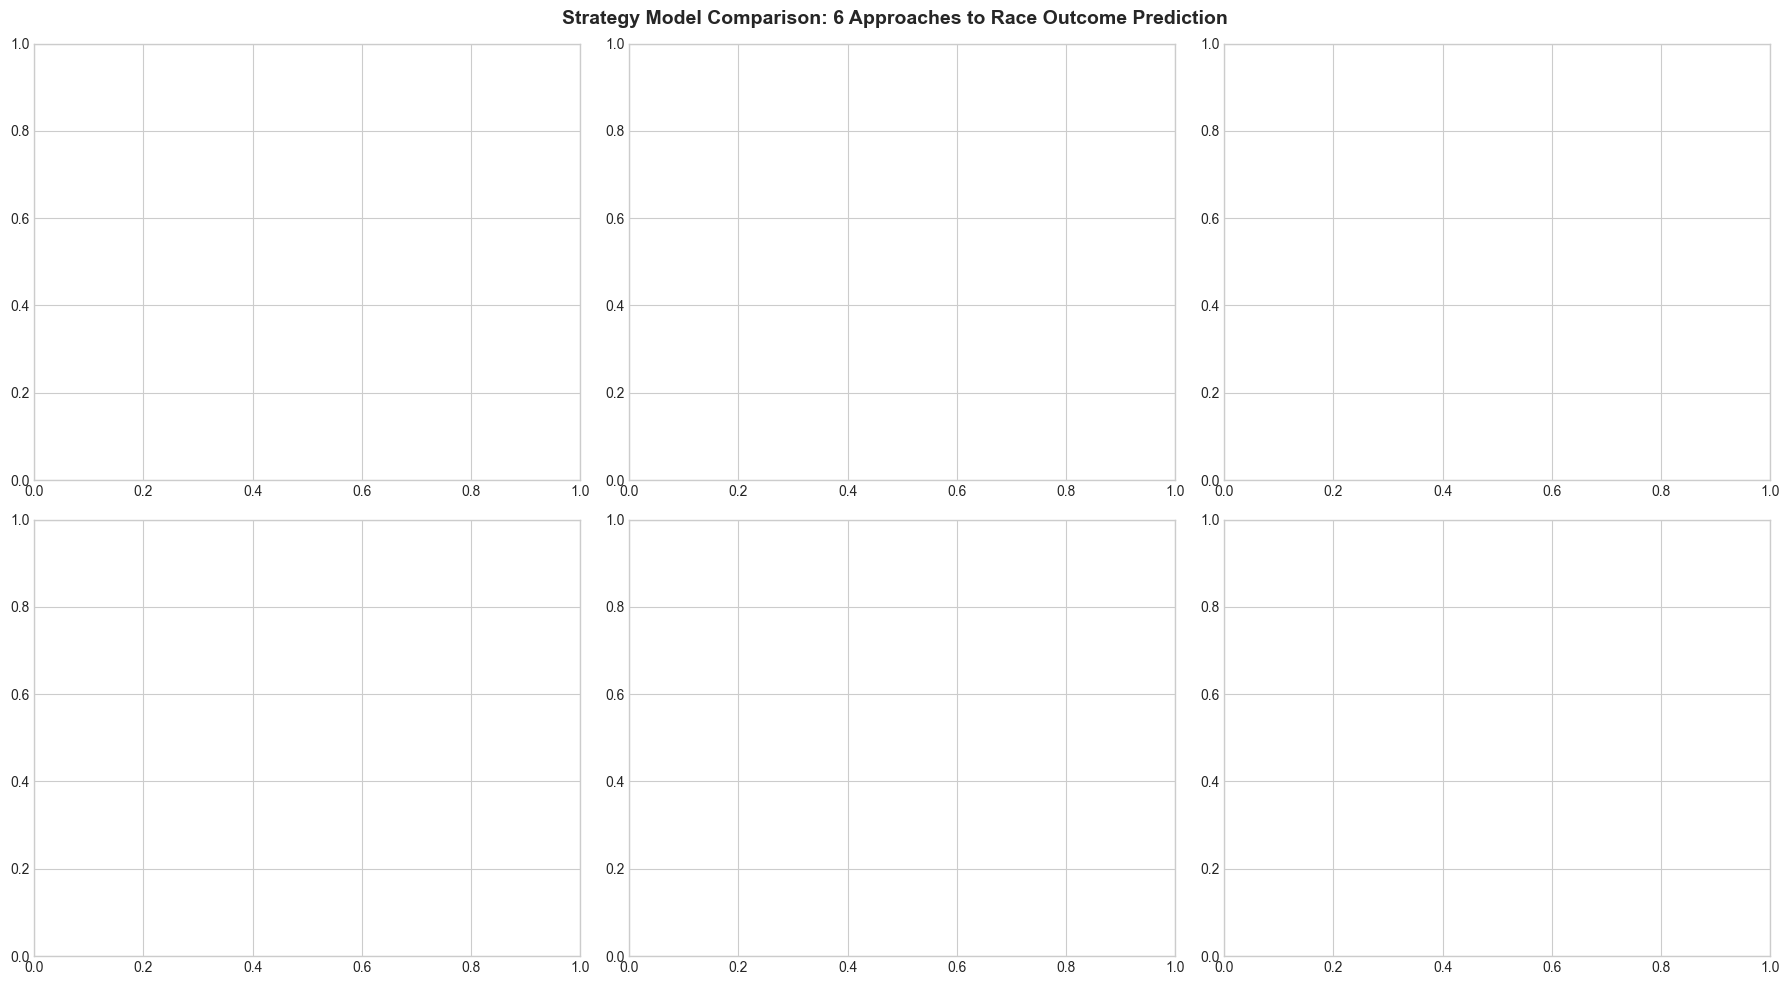

Compare the boundaries — which models best separate podium from midfield?


In [22]:
# EXERCISE 3: Race strategy decision boundary explorer
def plot_decision_boundary(clf, X, y, ax=None, title=''):
    """
    Plot the decision boundary of a fitted classifier on race data.
    
    Args:
        clf: A fitted sklearn classifier
        X: Feature matrix (n_samples, 2) — must be 2D (e.g., speed + downforce)
        y: Labels (0 = no podium, 1 = podium)
        ax: Matplotlib axes (creates new figure if None)
        title: Plot title
    """
    # TODO: Implement this!
    # 1. Create a mesh grid spanning the data range (with some padding)
    # 2. Predict on every point in the mesh
    # 3. Use contourf to color the regions
    # 4. Scatter plot the actual race data points on top
    # 5. Add title with the model's accuracy
    # Hint: Use np.meshgrid and clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    pass


# Test: Compare 6 strategy models on race data
X_ex3, y_ex3 = make_moons(n_samples=300, noise=0.2, random_state=42)
X_ex3_scaled = StandardScaler().fit_transform(X_ex3)

classifiers_ex3 = [
    ('Decision Tree', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('SVM (RBF)', SVC(kernel='rbf', random_state=42)),
    ('k-NN (k=5)', KNeighborsClassifier(n_neighbors=5)),
    ('Naive Bayes', GaussianNB()),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (name, clf) in enumerate(classifiers_ex3):
    row, col = idx // 3, idx % 3
    clf.fit(X_ex3_scaled, y_ex3)
    plot_decision_boundary(clf, X_ex3_scaled, y_ex3, ax=axes[row, col], title=name)

plt.suptitle('Strategy Model Comparison: 6 Approaches to Race Outcome Prediction', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Compare the boundaries — which models best separate podium from midfield?")

### Exercise 4: Telemetry Feature Importance Analysis

You're analyzing which telemetry channels matter most for predicting race outcomes. Train a Random Forest on race data and visualize which features (tire wear, fuel load, qualifying position, etc.) have the strongest predictive power. This is one of the biggest advantages of tree-based models — built-in feature importance that tells the engineering team where to focus.

In [23]:
# EXERCISE 4: Telemetry feature importance
def analyze_telemetry_importance(X, y, feature_names=None):
    """
    Train a Random Forest on race data and visualize which telemetry channels matter most.
    
    Args:
        X: Feature matrix (race telemetry data)
        y: Labels (podium / no podium)
        feature_names: List of telemetry channel names (optional)
    
    Returns:
        Sorted list of (feature_name, importance) tuples
    """
    # TODO: Implement this!
    # 1. Train a RandomForestClassifier on the data
    # 2. Extract .feature_importances_
    # 3. Sort features by importance (descending)
    # 4. Create a horizontal bar chart
    # 5. Return sorted (name, importance) tuples
    # Hint: If feature_names is None, use ["Channel 0", "Channel 1", ...]
    
    pass


# Test with simulated race telemetry
X_telemetry, y_telemetry = make_classification(n_samples=500, n_features=10, n_informative=3,
                                                n_redundant=2, random_state=42)

telemetry_channels = ['Quali Position', 'Tire Wear %', 'Fuel Load kg', 'Track Temp C',
                      'Downforce Level', 'Top Speed kph', 'Sector 1 Time', 'Sector 2 Time',
                      'Pit Stop Delta', 'Wind Speed kph']
result = analyze_telemetry_importance(X_telemetry, y_telemetry, telemetry_channels)

if result is not None:
    print("Telemetry channel importance for podium prediction:")
    for name, importance in result:
        bar = '#' * int(importance * 100)
        print(f"  {name:>17}: {importance:.4f} {bar}")
    
    # Verify: top 3 channels should capture most importance
    top3_importance = sum(imp for _, imp in result[:3])
    print(f"\nTop 3 channels capture {top3_importance:.1%} of total predictive power")
    assert top3_importance > 0.4, "Top 3 informative channels should capture >40% importance"
    print("Check passed!")
else:
    print("TODO: Implement analyze_telemetry_importance")

TODO: Implement analyze_telemetry_importance


---

## Summary

### Key Concepts

| Algorithm | What It Does | F1 Parallel |
|-----------|-------------|-------------|
| **Decision Trees** | Split data using yes/no questions, choosing splits that maximize information gain | Race strategy flowchart: "Is tire wear > 60%? Is rain expected?" |
| **Random Forests** (bagging) | Combine many trees trained on random data subsets, then vote | The full strategy room — each engineer analyzes different telemetry, then they vote |
| **Gradient Boosting** | Build trees sequentially, each correcting previous errors | Iterative debriefs — each session focuses on what went wrong last time |
| **SVMs** | Find the maximum-margin decision boundary; kernel trick handles nonlinearity | The optimal racing line — maximum clearance from both walls |
| **k-Means** | Iteratively assign points to nearest centers | Grouping circuits by characteristics (power tracks, street circuits, technical) |
| **DBSCAN** | Find clusters by density, handling arbitrary shapes and detecting noise | Finding natural circuit groupings and flagging outliers like Monaco |
| **k-NN** | Classify by majority vote of nearest neighbors | "Find me the 5 most similar past races" |
| **Naive Bayes** | Bayes' theorem with feature independence assumption | Quick probability estimates from independent race factors |
| **Model Evaluation** | Cross-validation, confusion matrices, appropriate metrics | Testing your strategy model across different race weekends, not just one |

### Connection to Deep Learning

| Classical ML Concept | Deep Learning Connection | F1 Parallel |
|---------------------|-------------------------|-------------|
| Decision tree splits | Feature thresholding in neural network activations (ReLU) | Telemetry threshold checks at each strategy decision point |
| Ensemble averaging | Dropout as implicit ensemble, model ensembles in production | Strategy room consensus — many engineers, one decision |
| Gradient boosting residuals | Residual connections in ResNets | Each debrief session builds on what came before |
| SVM kernel trick | Neural networks as learned feature mappings | Transforming raw telemetry into the right feature space |
| SVM maximum margin | Contrastive loss, triplet loss in embedding learning | Maximum clearance racing line between outcomes |
| k-Means centroids | Learned prototypes in prototype networks, VQ-VAE codebook | Prototype circuits that define each category |
| Cross-validation | Standard evaluation protocol for all ML models | Testing strategy across a full season, not just one race |
| Feature importance | Attention weights, gradient-based attribution (Grad-CAM) | Which telemetry channels the model pays attention to |
| Bias-variance tradeoff | Underfitting/overfitting in neural network training | Conservative vs aggressive strategy — consistent but slow vs fast but risky |
| Confusion matrix & ROC | Same evaluation tools used for deep learning classifiers | Same podium prediction evaluation, regardless of model complexity |

### Algorithm Selection Cheat Sheet

| Your Situation | Best Starting Point | Why | F1 Example |
|---------------|--------------------|----- |------------|
| Tabular data, any size | Gradient Boosting (XGBoost) | State-of-the-art on tabular data | Predicting lap times from telemetry spreadsheets |
| Need interpretability | Decision Tree or Logistic Regression | Transparent decision process | Explaining pit call logic to the team principal |
| Small dataset (< 1K) | Random Forest or SVM | Robust with limited data | One season of race results (20 races) |
| High-dimensional sparse data | Naive Bayes or Linear SVM | Fast, handles many features | Text analysis of team radio transcripts |
| No labels (unsupervised) | k-Means or DBSCAN | Discover natural groupings | Clustering circuits by characteristics |
| Quick baseline | k-NN or Naive Bayes | Minimal tuning required | Fast first-pass race outcome prediction |
| Images, text, audio | Deep Learning | Feature learning is key | Onboard camera analysis, radio sentiment |

### Checklist

- [ ] I can explain how a decision tree chooses splits using Gini impurity or information gain
- [ ] I understand why ensembles (bagging, boosting) outperform single models — like a strategy team vs. one engineer
- [ ] I can explain the SVM maximum margin concept (optimal racing line) and the kernel trick
- [ ] I can apply k-means and DBSCAN to cluster circuits, and know when each is appropriate
- [ ] I know the difference between precision, recall, and F1 score (yes, the F1 score in F1!)
- [ ] I can read a confusion matrix and ROC curve for podium prediction
- [ ] I use cross-validation (testing across multiple race weekends) instead of single train/test splits
- [ ] I know when to use classical ML vs deep learning — tabular telemetry data vs. camera footage
- [ ] I always start with a simple baseline before trying complex models

---

## Next Steps

In **Part 3.2: Optimization & Linear Programming**, we'll study the mathematical machinery that powers model training:
- Gradient descent and its variants (SGD, Adam, RMSprop)
- Convex vs non-convex optimization
- Constrained optimization and Lagrange multipliers
- Learning rate schedules and convergence

Understanding optimization is critical because **every ML model** — from the simplest decision tree split to the largest transformer — is trained by minimizing a loss function. The optimization algorithms we'll study next are the engine that makes learning possible. In F1 terms: if classical ML gives you the strategy toolkit, optimization theory is the aerodynamic engineering that makes the whole car go faster.